In [1]:
# 7/1/23
# Created by Andrew Muehr (originally in 2022)
# This code serves as a more efficient way to plot data from my 10 MLS simulatioms in Muehr et al. (in review)

import matplotlib.pyplot as plt
import matplotlib as mpl
from netCDF4 import Dataset
from pylab import rcParams
import numpy as np
from matplotlib.patches import Rectangle
from matplotlib import cm
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from scipy import stats
from scipy.stats import pearsonr

import math as m

In [54]:
# This block of code allows you to choose the simulation and time bounds for updraft tracking, 
# then finds the centroid of the updraft at each timsetep and stores it in two lists (x and y)

folder = "/glade/scratch/amuehr/"
#sim = "H5_14_moist_Mor/"
#sim = "H5_14_dry_Mor/"
sim = "H4_14_moist_Mor/"
#sim = "H4_14_dry_Mor/"
#sim = "H3_14_moist_Mor/"
#sim = "H3_14_dry_Mor/"
#sim = "H2_14_moist_Mor/"
#sim = "H2_14_dry_Mor/"
#sim = "H1_14_moist_Mor/"
#sim = "H1_14_dry_Mor/"

t0 = 60 # start of updraft tracking (simulation minutes)
t0 = int((t0+5)/5)
t1 = 120 # end of updraft tracking (simulation minutes)
t1 = int((t1+5)/5)

# Dimensions of CM1 domain
numy = 480 # ny
numx = 480 # nx
numz = 185 # nz

rm_center = True # trim domain so that only the right-mover is analyzed?
if rm_center == True: # trim domain (based on subjective analysis to isolate right-mover)
    if sim == "H5_14_moist_Mor/":
        x_start = 120
        y_start = 350
        xv_list = [(5 , -10),(-1 , -11),(7 , -7),(-4,-10),(-5 , -9),(-6 , -11),(-6 , -12),(-6 , -13),(-12 , -10),(-10 , -17),(2,-17),(3 , -20),(-2 , -15)]

    if sim == "H5_14_dry_Mor/":
        x_start = 110
        y_start = 353
        xv_list = [(-5 , -12),(-3 , -15),(1 , -15),(3 , -19),(4,-14),(9 , -17),(-10 , -19),(5,-18),(-7 , -19),(-7 , -14),(-7 , -16),(-7 , -18),(-7 , -13)]

    if sim == "H4_14_dry_Mor/":
        x_start = 120
        y_start = 333
        xv_list = [(-1 , -8),(-4 , -12),(-7 , -17),(2 , -7),(6 , -11),(7 , -18),(7 , -21),(-2 , -23),(2 , -14),(6 , -19),(4 , -20),(2 , -7),(4 , -17)]

    if sim == "H3_14_moist_Mor/":
        x_start = 100
        y_start = 335
        xv_list = [(11,-10),(-3 , -9),(-4 , -4),(-6 , -2),(0 , -12),(3 , -11),(4 , -14),(-7 , -15),(-2 , -16),(1 , -13),(3 , -10),(-1 , -12),(9 , -11)]

    if sim == "H2_14_moist_Mor/":
        x_start = 100
        y_start = 333
        xv_list = [(4 , -10),(-1 , -9),(-3 , -3),(5 , -7),(4 , -5),(-9 , -8),(-5 , -3),(-2 , -3),(-4 , -9),(-8 , -6),(-7 , -4),(-5 , -7),(3 , -7)]

    if sim == "H2_14_dry_Mor/":
        x_start = 80
        y_start = 331
        xv_list = [(-3 , -5),(-4 , -3),(-5 , -2),(-1 , -4),(10 , -13),(-10 , -1),(-1 , -17),(-9 , -2),(6 , -4),(5 , -4),(9 , -5),(8 , -11),(11 , -11)]

    if sim == "H3_14_dry_Mor/":
        x_start = 100
        y_start = 345
        xv_list = [(-5 , -2),(6 , -7),(-5 , -2),(3 , -2),(8 , -8),(-1 , -6),(4 , -11),(1 , -15),(2 , -7),(-2 , -12),(6 , -7),(-7 , -3),(-1 , -7)]

    if sim == "H4_14_moist_Mor/":
        x_start = 125
        y_start = 340
        xv_list = [(0 , -14),(-1 , -16),(-5 , -17),(4 , -19),(4,-25),(-5 , -23),(-8 , -18),(-5 , -19),(1 , -18),(1 , -18),(7 , -19),(2 , -17),(9 , -15)]

    if sim == "H1_14_dry_Mor/":
        x_start = 120
        y_start = 310
        xv_list = [(5,-9),(-3,-8),(1 , -1),(-5 , -3),(-5 , -3),(16 , -7),(17 , -13),(-1 , -6),(1 , -14),(1 , -4),(-2 , -3),(-2 , -4),(-4 , -11)]

    if sim == "H1_14_moist_Mor/":
        x_start = 150
        y_start = 332
        xv_list = [(0 , -7),(-4 , -8),(12 , -9),(-9 , -2),(-6 , -1),(11 , -1),(17 , -13),(9 , -18),(1 , -14),(-5 , -1),(-4 , -5),(-12 , -6),(4 , -11)]

center_list_x = [] # list of x-centroid of >75th percentile 3-6 km updraft at each timestep  
center_list_y = [] # list of x-centroid of >75th percentile 3-6 km updraft at each timestep  

file = folder + sim + 'cm1out_000001.nc' # first output file (t = 0)

data = Dataset(file) # Prepare netCDF data to be read in

xv_0 = data['xvort'][0,:,:,:] # initial x-vorticity 
yv_0 = data['yvort'][0,:,:,:] # initial y-vorticity

for a in range (t0, t1 + 1): # Updraft tracking
    if a < 10:
        file = folder + sim + 'cm1out_00000' + str(a) + '.nc' # add exception for the first 9 output files
    if a > 9:
        file = folder + sim + 'cm1out_0000' + str(a) + '.nc' # file name for the double-digit output times

    data = Dataset(file) # Prepare netCDF data to be read in 

    w_avg = np.zeros((y_start,numx)) # initialize array that will be filled with 3-6 km layer-averaged w for each timestep
    for a in range(30,61,1): 
        w_avg += data['w'][0,a,0:y_start,:] # add each layer of w within the trimmed domain
    w_avg = w_avg/31 # get layer average

    updraft = np.where(w_avg > 5) # get locations of where w exceeds 5 m/s
    updraft_w = w_avg[updraft] # get all values of 3-6 km layer-averaged w that exceed 5 m/s within the trimmed domain

    updraft_75 = np.percentile(updraft_w, 75) # Get 75 th percentile of all w > 5 values
    upd_75_vals = np.nonzero(w_avg > updraft_75) # Get locations of all w > 75th percentile within the RM updraft

    x_mean = np.mean(upd_75_vals[1]) # x-centroid of 75th percentile 3-6 km layer-averaged updraft
    y_mean = np.mean(upd_75_vals[0]) # y-centroid of 75th percentile 3-6 km layer-averaged updraft

    center_list_x.append(int(x_mean))
    center_list_y.append(int(y_mean))

In [55]:
# Read in data for time-averaged, updraft-centered plots

correction = False # correct for base-state vertical GRADIENT in horizontal vorticity? 
pp = True # Is dynamic pressure data available?

# Start (t0) and end (t1) times of time-average
t0 = 85 # start of time-average (simulation minutes)
t0 = int((t0+5)/5)
t1 = 85 # end of time-average (simulation minutes)
t1 = int((t1+5)/5)

dynamic_base = 0 # model level where of dynamic pressure acceleration and vertical gradients of vorticity calculations will begin (bottom)
dynamic_top = 60 # model level where of dynamic pressure acceleration and vertical gradients of vorticity calculations will end (top)

div = (t1 - t0) + 1 # Number of timesteps in the time-average. This is used to divide the data (i.e., get an average)

# Create empty 2D arrays to be filled with data (these will be RM-centered)
# General fields
thpert_sub = np.zeros((200,200))
dbz_sub = np.zeros((200,200))
w_sub = np.zeros((200,200))
w_avg = np.zeros((numy,numx)) # clear w_avg array from previous code block
zv_avg = np.zeros((numy,numx))
w_avg_sub = np.zeros((200,200))
zv_avg_sub = np.zeros((200,200))
ml_pta_avg_sub = np.zeros((200,200))
u_sub = np.zeros((200,200))
v_sub = np.zeros((200,200))
buoy_sub = np.zeros((200,200))

# Passive tracers
eil_sub = np.zeros((200,200))
ml_pta_avg = np.zeros((numy,numx)) # layer average

# Dynamics
zv_sub = np.zeros((200,200))
yv_sub = np.zeros((200,200))
xv_sub = np.zeros((200,200))

# Pressure (dynamic)
pdnl_sub = np.zeros((40,200,200)) # *** 3-DIMENSIONAL in order to take all values from 4-7 km ***
yv_layer_sub = np.zeros((40,200,200)) # *** 3-DIMENSIONAL in order to take all omega_y values from 4-7 km ***
xv_layer_sub = np.zeros((40,200,200)) # *** 3-DIMENSIONAL in order to take all omega_x values from 4-7 km ***
zv_layer_sub = np.zeros((40,200,200))
pdnl_mid_sub = np.zeros((200,200)) # p'NL at midlevels

# DPA terms
nldpa_sub = np.zeros((200,200))
ldpa_sub = np.zeros((200,200))

# Ratios
zeta_grad_sub = np.zeros((200,200))
omega_grad_sub = np.zeros((200,200))

# Create arrays to be filled with midlevel updraft attributes
area_arr = np.array([])
zv_arr = np.array([])
circ_arr = np.array([])
vrot_arr = np.array([])
pdnl_arr = np.array([])
pdnl_loc_x = np.array([])
pdnl_loc_y = np.array([])
vrot_75_arr = np.array([])
vrot_ml25_arr = np.array([])
vrot_ml10_arr = np.array([])
vrot_eil_arr = np.array([])
vrot_noneil_arr = np.array([])

vrot_mid_eil_arr = np.array([])


for a in range (t0, t1 + 1):
    if a > 9:
        file = folder + sim + 'cm1out_0000' + str(a) + '.nc'
    if a < 10:
        file = folder + sim + 'cm1out_00000' + str(a) + '.nc'
    print(file)
    data = Dataset(file) # Prepare netCDF data to be read in 

    w_avg = np.zeros((numy,numx)) # clear w_avg array from previous code block
    zv_avg = np.zeros((numy,numx))
    ml_pta_avg = np.zeros((numy,numx))

    if pp == True: 
        if a > 9:
            pp_file = folder + sim + 'dyn_0000' + str(a) + '.nc' # pressure decomposition files
        if a < 10:
            pp_file = folder + sim + 'dyn_00000' + str(a) + '.nc' # pressure decomposition files
        print(pp_file)
        pp_data = Dataset(pp_file) # Prepare pressure perturbation decomposition data to be read in

        pdnl = pp_data['p_dn'][40:80,:,:] #### IF YOU CHANGE THESE VALUES YOU MUST EDIT THE INITIALIZATION OF PDNL_SUB!!! ###
        yv_layer = data['yvort'][0,40:80,:,:] # for locating minimum p'NL where omega_h > 0.04 1/s
        xv_layer = data['xvort'][0,40:80,:,:] # for locating minimum p'NL where omega_h > 0.04 1/s
        zv_layer = data['zvort'][0,40:80,:,:]

        pdnl_mid = pp_data['p_dn'][60,:,:]
        print("CLEAR")

        # DPA terms (7/16/23)
        rho = data['rho'][0,dynamic_base:(dynamic_top-1),:,:] - data['rhopert'][0,dynamic_base:(dynamic_top-1),:,:] # 0-6 km base state rho
        #rho_mean = np.mean(rho, axis = (0))
        #rho_avg = rho_mean.reshape(480,480)

        # NLDPA
        nldpa_1 = (pp_data['p_dn'][(dynamic_base+1):dynamic_top,:,:] - pp_data['p_dn'][dynamic_base:(dynamic_top-1),:,:])*(1/rho)*(1/100) # dp'nl/dz
        nldpa_mean = np.mean(nldpa_1, axis=(0)) # mean dp'nl/dz over the specified layer
        nldpa = nldpa_mean.reshape(480,480)
        print("NLDPA FIRST:", np.amax(nldpa))

        # LDPA
        ldpa_1 = (pp_data['p_dl'][(dynamic_base+1):dynamic_top,:,:] - pp_data['p_dl'][dynamic_base:(dynamic_top-1),:,:])*(1/rho)*(1/100) # dp'l/dz
        ldpa_mean = np.mean(ldpa_1, axis=(0)) # mean dp'l/dz over the specified layer
        ldpa = ldpa_mean.reshape(480,480)

        # vertical gradients in omega_h and zeta
        zeta_grad_1 = ((data['zvort'][0,(dynamic_base+1):dynamic_top,:,:])**2) - ((data['zvort'][0,dynamic_base:(dynamic_top-1),:,:])**2) # dzeta/dz
        zeta_grad_mean = np.mean(zeta_grad_1, axis=(0)) # mean dzeta/dz over the specified layer
        zeta_grad = zeta_grad_mean.reshape(480,480)

        xv_prime =  data['xvort'][0,:,:,:] - xv_0 # storm-modified x-vorticty
        yv_prime =  data['yvort'][0,:,:,:] - yv_0 # storm-modified y-vorticity
        omega_grad_1 = (((((xv_prime[(dynamic_base+1):dynamic_top,:,:])**2) + ((yv_prime[(dynamic_base+1):dynamic_top,:,:])**2))**0.5)**2) - (((((xv_prime[dynamic_base:(dynamic_top-1),:,:])**2) + ((yv_prime[dynamic_base:(dynamic_top-1),:,:])**2))**0.5)**2) # domega_h/dz
        omega_grad_mean = np.mean(omega_grad_1, axis=(0)) # mean domega_h/dz over the specified layer
        omega_grad = omega_grad_mean.reshape(480,480)
        if correction == True:
            if sim == "H4_14_dry_Mor/" or "H4_14_moist_Mor/":
                omega_grad = omega_grad + 0.000009749979 # Correct for base-state vertical gradient in omega_h
                print("CORRECTED")


    dbz = data['dbz'][0,0,:,:]
    thpert = data['thpert'][0,0,:,:]
    u = data['u'][0,60,:,:]
    v = data['v'][0,60,:,:]
    w = data['w'][0,60,:,:]
    zv = data['zvort'][0,60,:,:]
    yv = data['yvort'][0,60,:,:]
    xv = data['xvort'][0,60,:,:]
    eil_pta = data['pt1'][0,60,:,:]
    buoy = data['buoyancy'][0,60,:,:]


    # Find 3-6 km layer-averaged midlevel tracer concentration
    for aa in range(60,61):
        ml_pta_avg += data['pt2'][0,aa,:,:] + data['pt3'][0,aa,:,:] + data['pt4'][0,aa,:,:]
    ml_pta_avg = ml_pta_avg/1

    for b in range(30,61): # 3-6 km layer-averaged w and zeta
        w_avg += data['w'][0,b,:,:]
        zv_avg += data['zvort'][0,b,:,:]
    w_avg = w_avg/30
    zv_avg = zv_avg/30

    try:
        dbz_sub_1 = dbz[(round(center_list_y[(a-13)])-60):(round(center_list_y[(a-13)])+140),(round(center_list_x[(a-13)])-60):(round(center_list_x[(a-13)])+140)] # 50 x 50 km subdomain of dbz for each timestep
        dbz_sub = dbz_sub + dbz_sub_1
       
        thpert_sub_1 = thpert[(round(center_list_y[(a-13)])-60):(round(center_list_y[(a-13)])+140),(round(center_list_x[(a-13)])-60):(round(center_list_x[(a-13)])+140)] # 50 x 50 km subdomain of thpert for each timestep
        thpert_sub = thpert_sub + thpert_sub_1

        u_sub_1 = u[(round(center_list_y[(a-13)])-60):(round(center_list_y[(a-13)])+140),(round(center_list_x[(a-13)])-60):(round(center_list_x[(a-13)])+140)] # 50 x 50 km subdomain of u for each timestep
        u_sub = u_sub + u_sub_1

        v_sub_1 = v[(round(center_list_y[(a-13)])-60):(round(center_list_y[(a-13)])+140),(round(center_list_x[(a-13)])-60):(round(center_list_x[(a-13)])+140)] # 50 x 50 km subdomain of v for each timestep
        v_sub = v_sub + v_sub_1

        w_sub_1 = w[(round(center_list_y[(a-13)])-60):(round(center_list_y[(a-13)])+140),(round(center_list_x[(a-13)])-60):(round(center_list_x[(a-13)])+140)] # 50 x 50 km subdomain of v for each timestep
        w_sub = w_sub + w_sub_1

        zv_sub_1 = zv[(round(center_list_y[(a-13)])-60):(round(center_list_y[(a-13)])+140),(round(center_list_x[(a-13)])-60):(round(center_list_x[(a-13)])+140)] # 50 x 50 km subdomain of v for each timestep
        zv_sub = zv_sub + zv_sub_1

        yv_sub_1 = yv[(round(center_list_y[(a-13)])-60):(round(center_list_y[(a-13)])+140),(round(center_list_x[(a-13)])-60):(round(center_list_x[(a-13)])+140)] # 50 x 50 km subdomain of v for each timestep
        yv_sub = yv_sub + yv_sub_1

        xv_sub_1 = xv[(round(center_list_y[(a-13)])-60):(round(center_list_y[(a-13)])+140),(round(center_list_x[(a-13)])-60):(round(center_list_x[(a-13)])+140)] # 50 x 50 km subdomain of v for each timestep
        xv_sub = xv_sub + xv_sub_1

        wavg_sub_1 = w_avg[(round(center_list_y[(a-13)])-60):(round(center_list_y[(a-13)])+140),(round(center_list_x[(a-13)])-60):(round(center_list_x[(a-13)])+140)] # 50 x 50 km subdomain of layer-averaged w for each timestep
        w_avg_sub = w_avg_sub + wavg_sub_1
        #print("MAX:", np.amax(wavg_sub_1))

        zvavg_sub_1 = zv_avg[(round(center_list_y[(a-13)])-60):(round(center_list_y[(a-13)])+140),(round(center_list_x[(a-13)])-60):(round(center_list_x[(a-13)])+140)] # 50 x 50 km subdomain of layer-averaged zeta for each timestep
        zv_avg_sub = zv_avg_sub + zvavg_sub_1

        eil_sub_1 = eil_pta[(round(center_list_y[(a-13)])-60):(round(center_list_y[(a-13)])+140),(round(center_list_x[(a-13)])-60):(round(center_list_x[(a-13)])+140)] # 50 x 50 km subdomain of v for each timestep
        eil_sub = eil_sub + eil_sub_1
        #print("MAX:", np.amax(eil_sub_1))

        ml_pta_avg_sub1 = ml_pta_avg[(round(center_list_y[(a-13)])-60):(round(center_list_y[(a-13)])+140),(round(center_list_x[(a-13)])-60):(round(center_list_x[(a-13)])+140)] # 50 x 50 km subdomain of ml pta avg for each timestep
        ml_pta_avg_sub = ml_pta_avg_sub + ml_pta_avg_sub1

        buoy_sub1 = buoy[(round(center_list_y[(a-13)])-60):(round(center_list_y[(a-13)])+140),(round(center_list_x[(a-13)])-60):(round(center_list_x[(a-13)])+140)] # 50 x 50 km subdomain of buoyancy for each timestep
        buoy_sub = buoy_sub + buoy_sub1

        if pp == True:
            # NOTE THAT THIS PDNL ARRAY IS 3-DIMENSIONAL; IT INCLUDES ALL LEVELS BETWEEN 4-7 KM
            pdnl_sub1 = pdnl[:,(round(center_list_y[(a-13)])-60):(round(center_list_y[(a-13)])+140),(round(center_list_x[(a-13)])-60):(round(center_list_x[(a-13)])+140)] # 50 x 50 km subdomain of p'NL for each timestep
            pdnl_sub = pdnl_sub + pdnl_sub1

            pdnl_mid_sub1 = pdnl_mid[(round(center_list_y[(a-13)])-60):(round(center_list_y[(a-13)])+140),(round(center_list_x[(a-13)])-60):(round(center_list_x[(a-13)])+140)] # 50 x 50 km subdomain of midlevel p'NL for each timestep
            pdnl_mid_sub = pdnl_mid_sub + pdnl_mid_sub1

            # Now we need to calculate omega over the 4-7 km layer
            yv_layer_sub1 = yv_layer[:,(round(center_list_y[(a-13)])-60):(round(center_list_y[(a-13)])+140),(round(center_list_x[(a-13)])-60):(round(center_list_x[(a-13)])+140)] # 50 x 50 km subdomain of yv_layer for each timestep
            yv_layer_sub = yv_layer_sub + yv_layer_sub1

            xv_layer_sub1 = xv_layer[:,(round(center_list_y[(a-13)])-60):(round(center_list_y[(a-13)])+140),(round(center_list_x[(a-13)])-60):(round(center_list_x[(a-13)])+140)] # 50 x 50 km subdomain of xv_layer for each timestep
            xv_layer_sub = xv_layer_sub + xv_layer_sub1

            zv_layer_sub1 = zv_layer[:,(round(center_list_y[(a-13)])-60):(round(center_list_y[(a-13)])+140),(round(center_list_x[(a-13)])-60):(round(center_list_x[(a-13)])+140)] # 50 x 50 km subdomain of zv_layer for each timestep
            zv_layer_sub = zv_layer_sub + zv_layer_sub1            

            # Find location of minimum p'NL within the 4-7 km layer 
            omega_h = (xv_layer_sub1**2 + yv_layer_sub1**2)**0.5 # calculate total horizontal vorticity
            omega_0_04 = np.nonzero(omega_h[:,0:100,0:85] > 0.04) # Find all locations within/near the updraft where horizontal vorticity exceeds 0.04 1/s
            pdnl_0_04 = pdnl_sub1[omega_0_04]
            pdnl_min = np.nonzero(pdnl_sub1 == np.min(pdnl_0_04))
            pdnl_min_val = float(np.amin(pdnl_0_04))
            pdnl_x = float(pdnl_min[1])
            pdnl_y = float(pdnl_min[2])
            pdnl_loc_x = np.append(pdnl_loc_x, [pdnl_x])
            pdnl_loc_y = np.append(pdnl_loc_y, [pdnl_y])
            pdnl_arr = np.append(pdnl_arr, pdnl_min_val)

            # NLDPA
            nldpa_sub1 = nldpa[(round(center_list_y[(a-13)])-60):(round(center_list_y[(a-13)])+140),(round(center_list_x[(a-13)])-60):(round(center_list_x[(a-13)])+140)] # 50 x 50 km subdomain of NLDPA for each timestep
            nldpa_sub = nldpa_sub + nldpa_sub1

            # LDPA
            ldpa_sub1 = ldpa[(round(center_list_y[(a-13)])-60):(round(center_list_y[(a-13)])+140),(round(center_list_x[(a-13)])-60):(round(center_list_x[(a-13)])+140)] # 50 x 50 km subdomain of LDPA for each timestep
            ldpa_sub = ldpa_sub + ldpa_sub1

            # Vertical gradients in omega_h and zeta
            zeta_grad_sub1 = zeta_grad[(round(center_list_y[(a-13)])-60):(round(center_list_y[(a-13)])+140),(round(center_list_x[(a-13)])-60):(round(center_list_x[(a-13)])+140)] # 50 x 50 km subdomain of zeta_grad for each timestep
            zeta_grad_sub = zeta_grad_sub + zeta_grad_sub1

            omega_grad_sub1 = omega_grad[(round(center_list_y[(a-13)])-60):(round(center_list_y[(a-13)])+140),(round(center_list_x[(a-13)])-60):(round(center_list_x[(a-13)])+140)] # 50 x 50 km subdomain of omega_grad for each timestep
            omega_grad_sub = omega_grad_sub + omega_grad_sub1

        # Calculate circulation and Vrot (using methods from Peters et al. 2023)
        mid_upd = np.nonzero(wavg_sub_1[0:110,0:100] > 10) # Find all points where 3-6 km layer-averaged w exceeds 10 m/s
        mid_size = ((np.shape(mid_upd))[1])*62500 # Find midlevel updraft area (in meters^2)
        area_arr = np.append(area_arr, [mid_size])
        #print("UPD AREA:", mid_size)
        print("mid_upd_shape:", np.shape(mid_upd))
        mid_vort = zvavg_sub_1[mid_upd]
        avg_vort = np.average(mid_vort)
        zv_arr = np.append(zv_arr, [avg_vort])
        #print("AVG ZETA:", avg_vort)
        mid_circ = avg_vort*mid_size # calculate circulation
        circ_arr = np.append(circ_arr, [mid_circ])
        #print("CIRC:", mid_circ)
        mid_vrot = mid_circ/((2*((m.pi)**0.5))*(mid_size**0.5))
        vrot_arr = np.append(vrot_arr, [mid_vrot])
        
        # Find vrot of midlevel updraft where EIL trac. conc. > 99%
        mid_eil = np.nonzero(eil_sub_1[0:110,0:100] > 99) # Find all points where the midlevel updraft contains > 99% EIL air
        mid_eil_size = ((np.shape(mid_eil))[1])*62500 # Find area of this undiluted region (in meters^2))
        mid_eil_vort = zvavg_sub_1[mid_eil] # Find values of vorticity where EIL trac. conc. > 99%
        avg_mid_eil_vort = np.average(mid_eil_vort) # Find average vorticity of region
        print("AVG VORT:", avg_mid_eil_vort)
        mid_eil_circ = avg_mid_eil_vort*mid_eil_size # calculate circulation
        mid_eil_vrot = mid_eil_circ/((2*((m.pi)**0.5))*(mid_eil_size**0.5)) # calculate vrot
        vrot_mid_eil_arr = np.append(vrot_mid_eil_arr, [mid_eil_vrot])
        
        
        mid_75_and_10 = False
        if mid_75_and_10 == True:
            # Calculate Vrot where ML trac. conc. > 10%, 25%, and where w > 75th percentile of midlevel updraft w (7/11/23)
            # 75th percentile updraft vrot:
            mid_upd_5 = np.nonzero(wavg_sub_1[0:110,0:100] > 5) # get locations of where 3-6 km layer-averaged w exceeds 5 m/s
            upd_5_size = (np.shape(mid_upd_5))[1]*62500 # Find midlevel > 75th percentile w updraft area (in meters^2)
            mid_upd_w = wavg_sub_1[mid_upd_5] # get all values of 3-6 km layer-averaged w that exceed 5 m/s within the trimmed domain
            mid_upd_75 = np.percentile(mid_upd_w, 75) # Get 75 th percentile of all w > 5 values
            upd_75_loc = np.nonzero(wavg_sub_1 > mid_upd_75) # Get locations of all w > 75th percentile within the RM updraft
            upd_75_vort = zvavg_sub_1[upd_75_loc] # Get values of vertical vorticity where w > 75th percentile midlevel updraft w
            upd_75_avg_vort = np.average(upd_75_vort) # Find average of vertical vorticity within the > 75th percentile midlevel updraft
            upd_75_circ = upd_5_size*upd_75_vort # Calculate circulation
            upd_75_vrot = upd_75_circ/((2*((m.pi)**0.5))*(upd_5_size**0.5)) # Calculate Vrot of > 75th percentile w midlevel updraft
            vrot_75_arr = np.append(vrot_75_arr, [upd_75_vrot])
            
            # ML trac. conc. > 25% vrot:
            ml_pta_10 = ml_pta_avg_sub1 > 10 # Midlevel tracer array where values exceed 10% (True or False)
            #print(ml_pta_10)
            ml_pta_10_int = ml_pta_10.astype(int) # Replace all instances of True with 1 and False with 0
            #print(ml_pta_10_int)
            mid_w_10 = wavg_sub_1 > 10 # Midlevel w array where values exceed 10 m/s (True or False)
            mid_w_10_int = mid_w_10.astype(int) # Replace all instances of True with 1 and False with 0
            #print(mid_w_10_int)
            array_of_2 = ml_pta_10_int + mid_w_10_int # In this array, a value of 2 exists where the two criteria are met
            locations = np.nonzero(array_of_2 == 2) # Find all locations where there is a value of 2
            #print(np.shape(locations))
            mid_pta_vort = zvavg_sub_1[locations] # vertical vorticity values where both criteria are met
            #print(np.shape(mid_pta_vort))
            mid_pta_size = int(np.shape(mid_pta_vort)[0])*62500 # Find area (in m2) of area where both criteria are met
            #print(np.mean(mid_pta_vort))
            mid_pta_circ = mid_pta_size*mid_pta_vort # calculate circulation
            mid_pta_vrot = mid_pta_circ/((2*((m.pi)**0.5))*(mid_pta_size**0.5)) # calculate rotational velocity
            vrot_ml25_arr = np.append(vrot_ml25_arr, [mid_pta_vrot])

        # EIL trac. conc. > 99% and w > 10 m/s
        deallocate = True
        if deallocate == True:
            eil_pta_99 = np.array([])
            eil_pta_99_int = np.array([])
            mid_w_10 = np.array([])
            mid_w_10_int = np.array([])
            array_of_2 = np.array([])
            locations = np.array([])
            eil_pta_vort = np.array([])
            avg_eil_vort = 0
            eil_pta_size = 0
            eil_pta_circ = 0
            eil_pta_vrot = 0

        '''
        eil_pta_99 = eil_sub_1[0:110,0:100] > 99 # EIL tracer array where values exceed 99% (True or False)
        eil_pta_99_int = eil_pta_99.astype(int) # Replace all instances of True with 1 and False with 0
        print(np.amax(eil_pta_99_int))
        mid_w_10 = wavg_sub_1[0:110,0:100] > 10 # Midlevel w array where values exceed 10 m/s (True or False)
        mid_w_10_int = mid_w_10.astype(int) # Replace all instances of True with 1 and False with 0
        print(np.amax(mid_w_10_int))
        array_of_2 = eil_pta_99_int + mid_w_10_int # In this array, a value of 2 exists where the two criteria are met
        print("SHAPE ARRAY OF 2:", np.shape(array_of_2))
        locations = np.nonzero(array_of_2 == 2) # Find all locations where there is a value of 2
        #locations = np.flip(locations, 0)
        print("LOCATION SIZE:", np.shape(locations))
        print("LOCATIONS:", locations)
        print("LOC TYPE:", type(locations))
        #locations = np.arr([locations[0], locations[1]])
        print("SHAPE VORT:", np.shape(zvavg_sub_1))
        eil_pta_vort = zvavg_sub_1[locations] # vertical vorticity values where both criteria are met
        print("EIL_PTA_VORT:", eil_pta_vort)
        avg_eil_vort = np.average(eil_pta_vort)
        print("AVG EIL VORT:", avg_eil_vort)
        eil_pta_size = int(np.shape(eil_pta_vort)[0])*62500 # Find area (in m2) of area where both criteria are met
        eil_pta_circ = eil_pta_size*avg_eil_vort # calculate circulation
        eil_pta_vrot = eil_pta_circ/((2*((m.pi)**0.5))*(eil_pta_size**0.5)) # calculate rotational velocity
        #print("EIL VROT:", eil_pta_vrot)
        vrot_eil_arr = np.append(vrot_eil_arr, [eil_pta_vrot])
        '''
        # EIL trac. conc. < 99%
        noneil_pta_99 = ml_pta_avg_sub1[0:110,0:100] > 1 # midlevel tracer array where values exceed 1% (True or False)
        noneil_pta_99_int = noneil_pta_99.astype(int) # Replace all instances of True with 1 and False with 0
        mid_w_10 = wavg_sub_1[0:110,0:100] > 10 # Midlevel w array where values exceed 10 m/s (True or False)
        mid_w_10_int = mid_w_10.astype(int) # Replace all instances of True with 1 and False with 0
        array_of_2 = noneil_pta_99_int + mid_w_10_int # In this array, a value of 2 exists where the two criteria are met
        locations = np.nonzero(array_of_2 == 2) # Find all locations where there is a value of 2
        noneil_pta_vort = zvavg_sub_1[locations] # vertical vorticity values where both criteria are met
        avg_noneil_vort = np.mean(noneil_pta_vort)
        print("AVG NONEIL VORT:", avg_noneil_vort)
        noneil_pta_size = int(np.shape(noneil_pta_vort)[0])*62500 # Find area (in m2) of area where both criteria are met
        noneil_pta_circ = noneil_pta_size*avg_noneil_vort # calculate circulation
        noneil_pta_vrot = noneil_pta_circ/((2*((m.pi)**0.5))*(noneil_pta_size**0.5)) # calculate rotational velocity
        print("NONEIL VROT:", noneil_pta_vrot)
        vrot_noneil_arr = np.append(vrot_noneil_arr, [noneil_pta_vrot])
        
    except:
        print("ERROR AT TIMESTEP", a)


# Divide by the number of timesteps (div) to get an average
dbz_sub = dbz_sub/div
thpert_sub = thpert_sub/div
u_sub = u_sub/div
v_sub = v_sub/div
w_sub = w_sub/div
zv_sub = zv_sub/div
yv_sub = yv_sub/div
xv_sub = xv_sub/div
w_avg_sub = w_avg_sub/div
zv_avg_sub = zv_avg_sub/div
eil_sub = eil_sub/div
pdnl_sub = pdnl_sub/div
buoy_sub = buoy_sub/div
zv_layer_sub = zv_layer_sub/div
xv_layer_sub = xv_layer_sub/div
yv_layer_sub = yv_layer_sub/div
nldpa_sub = nldpa_sub/div/((dynamic_top - dynamic_base) - 1)
ldpa_sub = ldpa_sub/div/((dynamic_top - dynamic_base) - 1)
zeta_grad_sub = zeta_grad_sub/div/((dynamic_top - dynamic_base) - 1)
omega_grad_sub = omega_grad_sub/div/((dynamic_top - dynamic_base) - 1)
pdnl_mid_sub = pdnl_mid_sub/div

print("AREA:", area_arr)
print("AVG AREA:", np.mean(area_arr))
print("ZV:", zv_arr.tolist())
print("AVG ZV:", np.mean(zv_arr))
print("CIRC:", circ_arr.tolist())
print("AVG CIRC:", np.mean(circ_arr))
print("VROT:", vrot_arr.tolist())
#print("AVG VROT:", np.mean(vrot_arr))

print("PDNL_MIN:", pdnl_arr.tolist())
print("AVG_PDNL:", np.mean(pdnl_arr))

#print("AVG UPD 75 VROT, AVG ML 25 VROT:", np.mean(vrot_75_arr), ",", np.mean(vrot_ml25_arr)) 


print("AVG VROT:", np.mean(vrot_arr))
print("AVG EIL VROT at 6km:", np.mean(vrot_eil_arr))
print("AVG NON-EIL VROT at 6km:", np.mean(vrot_noneil_arr))

#print("NEW: AVG VROT OF UNDILUTED 6-KM UPDRAFT:", np.mean(vrot_mid_eil_arr))

print("MIN:", np.min(pdnl_mid_sub))

#print("nldpa_max:", np.amax(nldpa_sub))
#print("zeta_grad_max:", np.amax(zeta_grad_sub))

/glade/scratch/amuehr/H4_14_moist_Mor/cm1out_000018.nc
/glade/scratch/amuehr/H4_14_moist_Mor/dyn_000018.nc
CLEAR
NLDPA FIRST: 0.027175590143365375
mid_upd_shape: (2, 1111)
AVG VORT: 0.005252934663939065
AVG NONEIL VORT: 0.008791877608520928
NONEIL VROT: 13.18214024282603
AREA: [69437500.]
AVG AREA: 69437500.0
ZV: [0.006429011206974917]
AVG ZV: 0.006429011206974917
CIRC: [446414.46568432084]
AVG CIRC: 446414.46568432084
VROT: [15.112499132896081]
PDNL_MIN: [-474.69140625]
AVG_PDNL: -474.69140625
AVG VROT: 15.112499132896081
AVG EIL VROT at 6km: nan
AVG NON-EIL VROT at 6km: 13.18214024282603
MIN: -360.43359375


(40.0, 86.0, 30.0, 76.0)

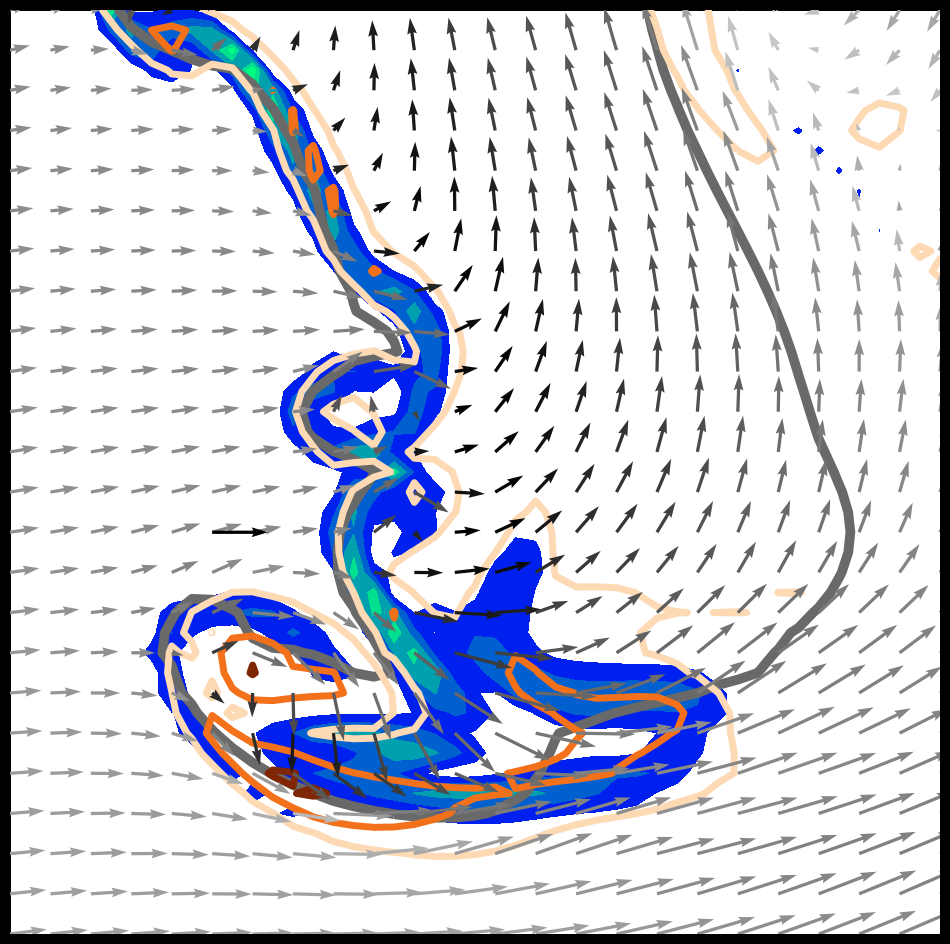

In [58]:
# This block of code produces plan views of the RM updraft-centered, time-averaged data
plt.rcParams["figure.figsize"] = (12,12)
plt.figure(linewidth = 15, edgecolor = "black", facecolor = "white")


def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100): # Block of code used to extract specific ranges of colorbars
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
'''
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,20)) # Set figure size and subplots
ax1.set_facecolor("black") # Background color
ax2.set_facecolor("white") # Background color


# Plot data
refl_cmap = cm.get_cmap("gist_ncar") # Get reflectivity colormap
im1 = ax1.contourf(dbz_sub, cmap = refl_cmap, vmin = 0, vmax = 75.0, levels = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75])
#im2 = ax1.contour(thpert_sub, levels = [-5, -1, 1, 5], cmap = plt.get_cmap("coolwarm"))

# Plot vectors
k = 10 # Number of gridpoints between each plotted arrow
x,y = np.meshgrid(np.arange(0,200,k),np.arange(0,200,k)) # Create meshgrid with same dimensions as RM-centered arrays
#ax1.quiver(x,y,u_sub[::k,::k],v_sub[::k,::k],scale=500,width=0.0035,zorder=50,color="gray")

# Colorbars
plt.colorbar(im1, ax=ax1)

# Limits

#ax1.set_xticks([]) # Turns off x-ticks
#ax1.set_yticks([]) # Turns off y-ticks
'''
# Second plot
# Colormaps
zv_cmap = ["crimson","deeppink","fuchsia","violet","thistle","gainsboro","whitesmoke"]
neg_zv_cmap = ["midnightblue","mediumblue","blue","dodgerblue","deepskyblue","skyblue","lightskyblue"]
w_cmap = plt.get_cmap("YlOrRd")

# Plot data
zvort_cmap = cm.get_cmap("bwr")
#ax2.contourf(zv_sub, levels = [-0.1, -0.01, -0.005, -0.002, 0.002, 0.005, 0.01, 0.1], cmap = zv_cmap)
#im2 = plt.contourf(zv_sub, levels = [0.005, 0.02, 0.04, 0.06, 0.08, 0.1,1], colors = zv_cmap)
#im2 = plt.contour(zv_sub, levels = [0.05], colors = ["purple"], linewidths = 5)
#im3 = plt.contourf(zv_sub, levels = [-1,-0.1,-0.08,-0.06,-0.04,-0.02,-0.005], colors = neg_zv_cmap)
#plt.contour(zv_sub, levels = [0.04], colors = ["deeppink"], linewidths = 3, linestyles = "--", zorder = 11) # 0.04 1/s zeta contour
#plt.contour(zv_sub, levels = [-0.04], colors = ["mediumblue"], linewidths = 3, linestyles = "--", zorder = 11) # -0.04 1/s zeta contour
#ax2.contourf(zv_sub, levels = [-0.002, 0.002], colors = ["black"])
plt.contour(w_sub, levels = [10], colors = ["dimgrey"], linewidths = 7) # 10 m/s updraft outline
#plt.contour(w_avg_sub, levels = [10], colors = ["dimgrey"], linewidths = 5) # 10 m/s updraft outline
#plt.contour(w_avg_sub, levels = [10, 15, 20, 25, 30], colors = ["dimgrey"], linewidths = 5) # 10, 15, 20, 25, 30 m/s updraft outline
#plt.contour(eil_sub, levels = [99], colors = ["black"], linestyles = "--", linewidths = 5)
#ax2.contourf(buoy_sub, levels = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4], cmap = w_cmap) # plot buoyancy
buoy_grad = (((buoy_sub[0:199,1:200] - buoy_sub[0:199,0:199])/250)**2 + ((buoy_sub[1:200,0:199] - buoy_sub[0:199,0:199])/250)**2)**0.5
winter = plt.get_cmap("winter")
plt.contourf(buoy_grad, levels = [0.0002, 0.0004, 0.0006, 0.0008, 0.001], cmap = winter) # plot buoyancy gradient
plt.contourf(buoy_grad, levels = [0.001,100], colors = [winter(0.9999)]) # plot buoyancy gradient
#plt.contourf((xv_sub**2 + yv_sub**2)**0.5, levels = [0.02, 0.04, 0.06, 0.08, 0.1], cmap = truncate_colormap(plt.get_cmap("Oranges"), 0.2,0.8)) # plot horizontal vorticity
plt.contour((xv_sub**2 + yv_sub**2)**0.5, levels = [0.02, 0.06, 0.1], cmap = truncate_colormap(plt.get_cmap("Oranges"), 0.2,0.99999), linewidths = 5) # plot horizontal vorticity
#plt.contourf((xv_sub**2 + yv_sub**2)**0.5, levels = [0.1, 1], cmap = truncate_colormap(plt.get_cmap("Oranges"), 0.8,1), linewidths = 3) # plot horizontal vorticity

# NLDPA 
s = plt.get_cmap("seismic")
#plt.contourf(nldpa_sub, zorder = 8, cmap = s, levels = [-0.002,-0.0016,-0.0012,-0.0008,-0.0004,0,0.0004,0.0008,0.0012,0.0016,0.002])
#plt.contourf(nldpa_sub, cmap = truncate_colormap(s, 0.9999999,0.6), levels = [-0.002,-0.0016,-0.0012,-0.0008,-0.0004]) # 1-6 or 0-6 km
#plt.contourf(nldpa_sub, cmap = truncate_colormap(s, 0.5,0.25), levels = [0.0004,0.0008,0.0012,0.0016,0.002]) # 1-6 or 0-6 km NEGATIVE
#plt.colorbar()
#plt.contourf(nldpa_sub, colors = [s(0.2)], levels = [0.002, 1000]) # 1-6 or 0-6 km NEGATIVE EXTREME
#plt.colorbar()
#plt.contourf(nldpa_sub, cmap = truncate_colormap(s, 0.9999999,0.6), levels = [-0.02,-0.016,-0.012,-0.008,-0.004]) # 0-1 km t = 105 H5-moist
#plt.contourf(nldpa_sub, cmap = truncate_colormap(s, 0.5,0.1), levels = [0.004,0.008,0.012,0.016,0.020]) # 0-1 km t = 105 H5-moist NEGATIVE
#plt.contourf(nldpa_sub, cmap = truncate_colormap(s, 0.9999999,0.6), levels = [-0.2,-0.16,-0.12,-0.08,-0.04]) # 0-1 km t = 170 H5-moist
#plt.contourf(nldpa_sub, cmap = s)

#plt.colorbar()
#plt.contourf(nldpa_sub, colors = [s(0.9999)], levels = [-1000,-0.002]) # Fill in extreme values # 1-6 or 0-6 km
#plt.contourf(nldpa_sub, colors = [s(0.9999)], levels = [-1000,-0.02]) # Fill in extreme values # 0-1 km t = 105 H5-moist
#plt.contourf(nldpa_sub, colors = [s(0.9999)], levels = [-1000,-0.2]) # Fill in extreme values # 0-1 km t = 170 H5-moist

#plt.contourf(nldpa_sub, zorder = 8.5, colors = ["dimgrey"], levels = [-0.0004,0.0004]) # Add GRAY in between red and blue
#plt.contourf(zeta_grad_sub)
#plt.colorbar()

# Find where omega_grads_sub > 0 ()
grad_pos = omega_grad_sub > 0 # array where omega_grad > 0
grad_pos_int = grad_pos.astype(int) # Replace all instances of True with 1 and False with 0

omega_larger = abs(omega_grad_sub) - abs(zeta_grad_sub) > 0 # array where omega_grad is larger in magntiude than zeta_grad
omega_larger_int = omega_larger.astype(int) # Replace all instances of True with 1 and False with 0

array_2 = grad_pos_int + omega_larger_int # In this array, a value of 2 exists where the two criteria are met
locs = np.nonzero(array_2 == 2) # Find all locations where there is a value of 2
#print(np.shape(locations))
omega_grad_pos_large = omega_grad_sub[locs] # omega_grad values where both criteria are met

#plt.contourf(abs(omega_grad_sub) - abs(zeta_grad_sub), zorder = 9, linewidths = 2) # plt.colorbar()
#plt.colorbar()
#plt.contourf(omega_grad_sub/zeta_grad_sub, levels = [-1,1], colors = ["black"], zorder = 9, linewidths = 2) # 
#plt.colorbar()
#plt.contourf(omega_grad_sub, zorder = 9, levels = [-1000,0], colors = 'none', hatches = ["//"], linewidths = 2) # 
#plt.contour(array_2, levels = [1.5], colors = ["blue"], zorder = 10, linewidths = 2)
#plt.contourf(array_2, levels = [1.5,100], colors = 'none', hatches = ["\\"])
#plt.colorbar()

# LDPA
#plt.contourf(-ldpa_sub, levels = [-0.0004, -0.0003, -0.0002, -0.0001, 0.0001, 0.0002, 0.0003, 0.0004], cmap = s)
#plt.contourf(ldpa_sub, levels = [-0.00045, -0.00035, -0.00025, -0.00015, -0.00005], cmap = truncate_colormap(s, 0.25,0.5))
#plt.contourf(ldpa_sub, levels = [0.00005, 0.00015, 0.00025, 0.00035, 0.00045], cmap = truncate_colormap(s, 0.6,0.9999999))
#plt.contour(-ldpa_sub, cmap = s)
#plt.colorbar()



# Dynamic pressure
#plt.contour(pdnl_mid_sub/100, levels = [-10,-8,-6,-4,-2,-1,1,2,4,6,8,10], cmap = plt.get_cmap("seismic"), linewidths = 5, zorder = 10) 


# Plot minimum p'NL in the 4-7 km layer (group of lines below) 8/8/23
#plt.contour((np.min(pdnl_sub, axis = 0))/100, levels = [-10,-8,-6,-4,-2,-1,1,2,4,6,8,10], cmap = plt.get_cmap("seismic"), linewidths = 5, zorder = 10) 
min_pdnl_sub = pdnl_sub == np.min(pdnl_sub, axis = 0)
min_pdnl_int = min_pdnl_sub.astype(int) # replace all instances of true with 1 and false with zero
omegah_larger = (((xv_layer_sub**2) + (yv_layer_sub**2))**0.5) > abs(zv_layer_sub) # where omega_h is larger than zeta in the 4-8 km layer
omegah_larger_int = omegah_larger.astype(int) # replace all instances of true with 1 and false with zero
true_array = min_pdnl_int + omegah_larger_int # Values of 2 occur where both criteria are met (i.e., is omega_h larger than zeta where 4-8 km pdnl is lowest?)
#plt.contourf(np.max(true_array, axis = 0), levels = [0,1.5], colors = 'none', hatches = ["//", "xxx", "xxxxx"], zorder = 10) 

#plt.contour(np.max((((xv_layer_sub**2) + (yv_layer_sub**2))**0.5), axis = 0), levels = [0.08], colors = ["orange"], linewidths = 5) # 0-1 km H5-moist plot
#print(np.max(true_array, axis = 0))
#print(np.min(true_array, axis = 0))

#plt.colorbar()

# Plot vectors
k = 2 # Number of gridpoints between each plotted arrow
x,y = np.meshgrid(np.arange(0,200,k),np.arange(0,200,k)) # Create meshgrid with same dimensions as RM-centered arrays
w_arrow = w_sub[::k,::k]/70
g = plt.get_cmap("Greys")
g = truncate_colormap(g, 0.3,1)
plt.quiver(x,y,u_sub[::k,::k],v_sub[::k,::k],w_arrow,scale=500,width=0.0035,zorder=50, cmap=g)
plt.quiver(50,50,30,0,scale=500,width=0.0035,zorder=50, color = ["black"]) # Reference vector

# Plot path of cross section
x = 60
#plt.vlines(x, 20, 92, linestyles = "--", color = "gray")
#plt.vlines(62, 20, 100, linestyles = "--", color = "gray") # H5 moist figure
y = 49
#plt.hlines(y, 44, 76, linestyles = "--", color = "gray")

# Testing: plot locations of minimum p'NL where omega_h > 0.04 1/s at each timestep
#if pp == True:
#    for a in range(0, div):
#        plt.scatter(pdnl_loc_x[a], pdnl_loc_y[a], marker = "+", color = "limegreen", s = 200, lw = 3)

#plt.scatter(locations[0], locations[1])
    

# Colorbars
#plt.colorbar(im2, ax=ax2)
#plt.colorbar(im3, ax=ax2)

# Limits
plt.xlim([30,110]) # zoomed-in view of updraft/mesocyclone
plt.ylim([30,110]) # zoomed-in view of updraft/mesocyclone
#plt.xlim([30,110]) # user-defined view
#plt.ylim([0,80]) # user-defined view
#plt.xlim([30,110]) # H5-moist t = 105 min
#plt.ylim([20,100]) # H5-moist t = 105 min
plt.xlim([40,86]) # Zoom in on southern edge of updraft 
plt.ylim([30,76]) # Zoom in on southern edge of updraft H4-moist-H5
#plt.ylim([40,86]) # Zoom in on southern edge of updraft H1-H3 and H4-dry
plt.xticks([]) # Turns off x-ticks
plt.yticks([]) # Turns off y-ticks
plt.axis("off")


ValueError: X and Y must be the same size, but X.size is 1 and Y.size is 2500.

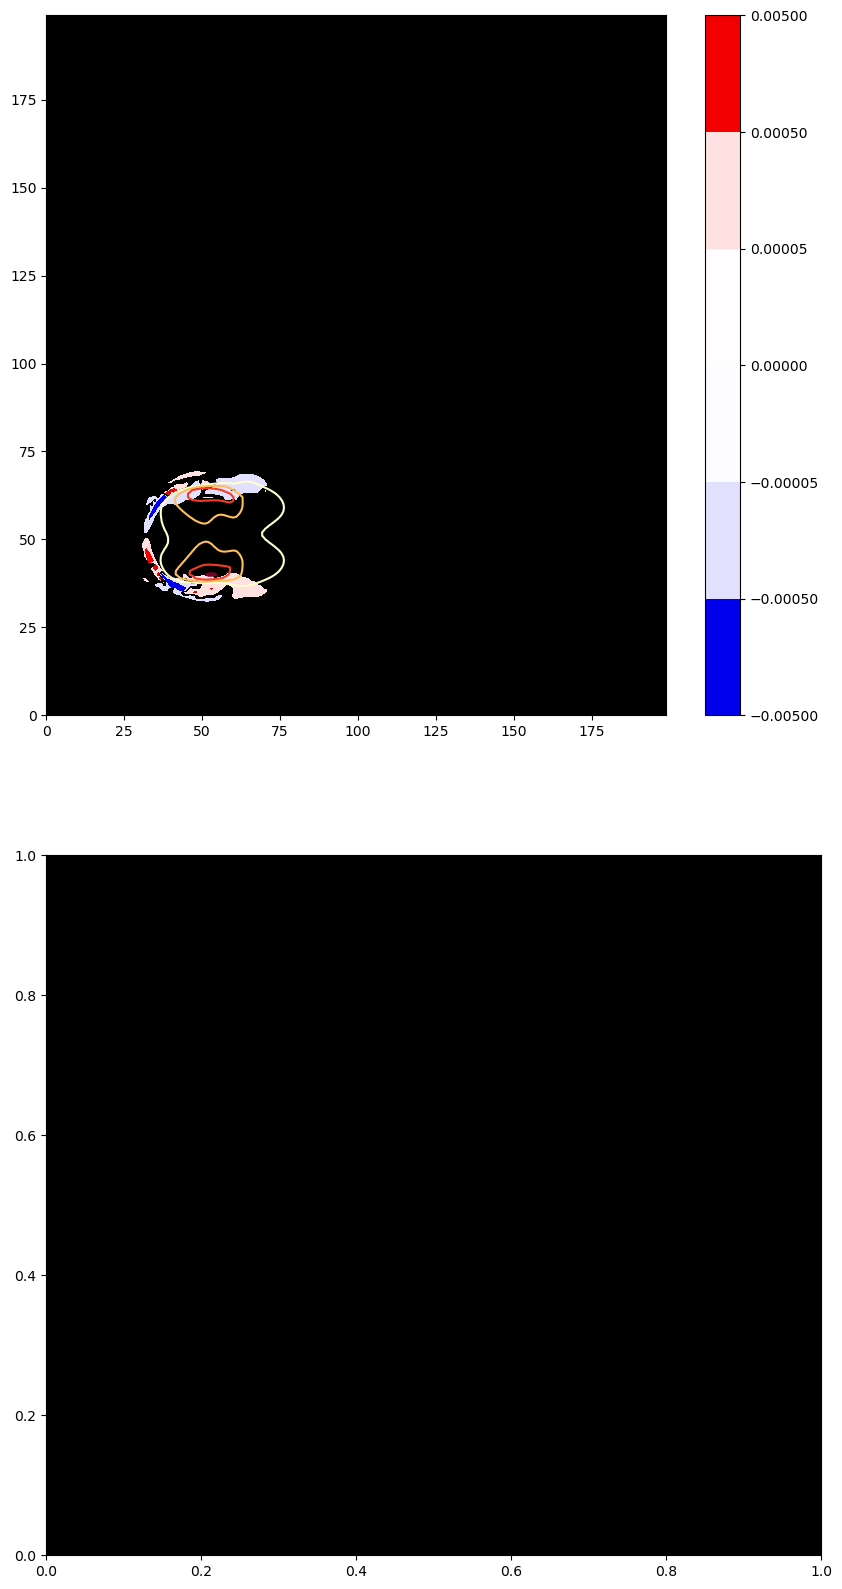

In [55]:
# Plot terms of the vorticity tendency equation
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,20)) # Set figure size and subplots
ax1.set_facecolor("black") # Background color
ax2.set_facecolor("black") # Background color

# TILTING
udir = abs(u_sub[1:200,:])/u_sub[1:200,:] # Sign of u wind
vdir = abs(v_sub[:,1:200])/v_sub[:,1:200] # Sign of v wind

dwdx = (w_sub[1:200,:] - w_sub[0:199,:])/250 # dw/dx, 250 m grid spacing
dwdy = (w_sub[:,1:200] - w_sub[:,0:199])/250 # dw/dy, 250 m grid spacing

tiltx = (udir*dwdx) # Get sign of tilting based on Vh direction
tilty = (vdir*dwdy) # Get sign of tilting based on Vh direction
tilting = ((tiltx[:,1:200]*yv_sub[1:200,1:200]) + (tilty[1:200,:]*xv_sub[1:200,1:200])) # tilting term (multiply by horizontal vorticity)

im1 = ax1.contourf(tilting, levels = [-0.005, -0.0005, -0.00005, 0, 0.00005, 0.0005, 0.005], cmap = plt.get_cmap("seismic"))
ax1.contourf(tilting, levels = [-0.00005, 0.00005], colors = ["black"])

im2 = ax1.contour(w_sub, levels = [5, 10, 15, 20], cmap = plt.get_cmap("YlOrRd"))
plt.colorbar(im1, ax=ax1)

ax1.quiver(x,y,u_sub[::k,::k],v_sub[::k,::k],scale=500,width=0.0035,zorder=50,color="gray")


ax1.set_xlim([30,110]) # standard
ax1.set_ylim([20,100]) # standard

In [42]:
# 7/5/23 This block of code reads in data for cross sections

pp = True # Is dynamic pressure data available?

# Start (t0) and end (t1) times of time-average
t0 = 65 # start of time-average (simulation minutes)
t0 = int((t0+5)/5)
t1 = 65 # end of time-average (simulation minutes)
t1 = int((t1+5)/5)

div = (t1 - t0) + 1 # Number of timesteps in the time-average. This is used to divide the data (i.e., get an average)

# Initialize empty arrays to be filled with data 
w_cross = np.zeros((150,200,200))
zv_cross = np.zeros((150,200,200))
xv_cross = np.zeros((150,200,200))
yv_cross = np.zeros((150,200,200))
omega_cross = np.zeros((150,200,200))
cloud_cross = np.zeros((150,200,200))
u_cross = np.zeros((150,200,200))
v_cross = np.zeros((150,200,200))
eil_pta_cross = np.zeros((150,200,200))
ml_pta_cross = np.zeros((150,200,200))
pdnl_cross = np.zeros((150,200,200))
pdl_cross = np.zeros((150,200,200))
buoy_cross = np.zeros((150,200,200))

# Find initial x- and y-vorticity
file = folder + sim + 'cm1out_000001.nc' # first output file (t = 0)
data = Dataset(file) # Prepare netCDF data to be read in
xv_0 = data['xvort'][0,:,:,:] # initial x-vorticity 
yv_0 = data['yvort'][0,:,:,:] # initial y-vorticity


for a in range (t0, t1 + 1):
    if a < 10:
        file = folder + sim + 'cm1out_00000' + str(a) + '.nc'
    if a > 9:
        file = folder + sim + 'cm1out_0000' + str(a) + '.nc'
    print(file)
    data = Dataset(file) # Prepare netCDF data to be read in 

    if pp == True: 
        if a > 9:
            pp_file = folder + sim + 'dyn_0000' + str(a) + '.nc' # pressure decomposition files
        if a < 10: 
            pp_file = folder + sim + 'dyn_00000' + str(a) + '.nc' # pressure decomposition files
        print(pp_file)
        pp_data = Dataset(pp_file) # Prepare pressure perturbation decomposition data to be read in

        pdnl = pp_data['p_dn'][:,:,:]
        pdl = pp_data['p_dl'][:,:,:]

        pdnl_cross1 = pdnl[0:150,(round(center_list_y[a-13])-60):(round(center_list_y[a-13])+140),(round(center_list_x[a-13])-60):(round(center_list_x[a-13])+140)]
        pdnl_cross = pdnl_cross + pdnl_cross1

        pdl_cross1 = pdl[0:150,(round(center_list_y[a-13])-60):(round(center_list_y[a-13])+140),(round(center_list_x[a-13])-60):(round(center_list_x[a-13])+140)]
        pdl_cross = pdl_cross + pdl_cross1


    w = data['w'][0,:,:,:]
    zv = data['zvort'][0,:,:,:] 
    xv = data['xvort'][0,:,:,:] - xv_0 # correct for initial x-vorticity
    yv = data['yvort'][0,:,:,:] - yv_0 # correct for initial y-vorticity
    qc = data['qc'][0,:,:,:]
    qi = data['qi'][0,:,:,:]
    cloud = qc + qi
    u = data['u'][0,:,:,:]
    v = data['v'][0,:,:,:]
    eil_pta = data["pt1"][0,:,:,:]
    ml_pta = data["pt2"][0,:,:,:] + data["pt3"][0,:,:,:] + data["pt4"][0,:,:,:]
    buoy = data["buoyancy"][0,:,:,:]
        
    cloud_cross1 = cloud[0:150,(round(center_list_y[a-13])-60):(round(center_list_y[a-13])+140),(round(center_list_x[a-13])-60):(round(center_list_x[a-13])+140)]
    cloud_cross = cloud_cross + cloud_cross1
    
    w_cross1 = w[0:150,(round(center_list_y[a-13])-60):(round(center_list_y[a-13])+140),(round(center_list_x[a-13])-60):(round(center_list_x[a-13])+140)]
    w_cross = w_cross + w_cross1

    zv_cross1 = zv[0:150,(round(center_list_y[a-13])-60):(round(center_list_y[a-13])+140),(round(center_list_x[a-13])-60):(round(center_list_x[a-13])+140)]
    zv_cross = zv_cross + zv_cross1

    xv_cross1 = xv[0:150,(round(center_list_y[a-13])-60):(round(center_list_y[a-13])+140),(round(center_list_x[a-13])-60):(round(center_list_x[a-13])+140)]
    xv_cross = xv_cross + xv_cross1

    yv_cross1 = yv[0:150,(round(center_list_y[a-13])-60):(round(center_list_y[a-13])+140),(round(center_list_x[a-13])-60):(round(center_list_x[a-13])+140)]
    yv_cross = yv_cross + yv_cross1

    u_cross1 = u[0:150,(round(center_list_y[a-13])-60):(round(center_list_y[a-13])+140),(round(center_list_x[a-13])-60):(round(center_list_x[a-13])+140)]
    u_cross = u_cross + u_cross1

    v_cross1 = v[0:150,(round(center_list_y[a-13])-60):(round(center_list_y[a-13])+140),(round(center_list_x[a-13])-60):(round(center_list_x[a-13])+140)]
    v_cross = v_cross + v_cross1

    eil_pta_cross1 = eil_pta[0:150,(round(center_list_y[a-13])-60):(round(center_list_y[a-13])+140),(round(center_list_x[a-13])-60):(round(center_list_x[a-13])+140)]
    eil_pta_cross = eil_pta_cross + eil_pta_cross1

    ml_pta_cross1 = ml_pta[0:150,(round(center_list_y[a-13])-60):(round(center_list_y[a-13])+140),(round(center_list_x[a-13])-60):(round(center_list_x[a-13])+140)]
    ml_pta_cross = ml_pta_cross + ml_pta_cross1

    buoy_cross1 = buoy[0:150,(round(center_list_y[a-13])-60):(round(center_list_y[a-13])+140),(round(center_list_x[a-13])-60):(round(center_list_x[a-13])+140)]
    buoy_cross = buoy_cross + buoy_cross1

w_cross = w_cross/div
cloud_cross = cloud_cross/div
zv_cross = zv_cross/div
xv_cross = xv_cross/div
yv_cross = yv_cross/div
u_cross = u_cross/div
v_cross = v_cross/div
eil_pta_cross = eil_pta_cross/div
ml_pta_cross = ml_pta_cross/div
pdnl_cross = pdnl_cross/div
pdl_cross = pdl_cross/div
buoy_cross = buoy_cross/div

/glade/scratch/amuehr/H4_14_dry_Mor/cm1out_000014.nc
/glade/scratch/amuehr/H4_14_dry_Mor/dyn_000014.nc


/glade/scratch/amuehr/ipykernel_1243/2390121618.py:23: UserWarning: linewidths is ignored by contourf
  plt.contourf(cloud_cross[:,0:120,x], levels=[0.00001,1000], colors=["gray"], linewidths = 8, zorder = 1, alpha = 0.4) # plot cloud


<Figure size 1200x1200 with 0 Axes>

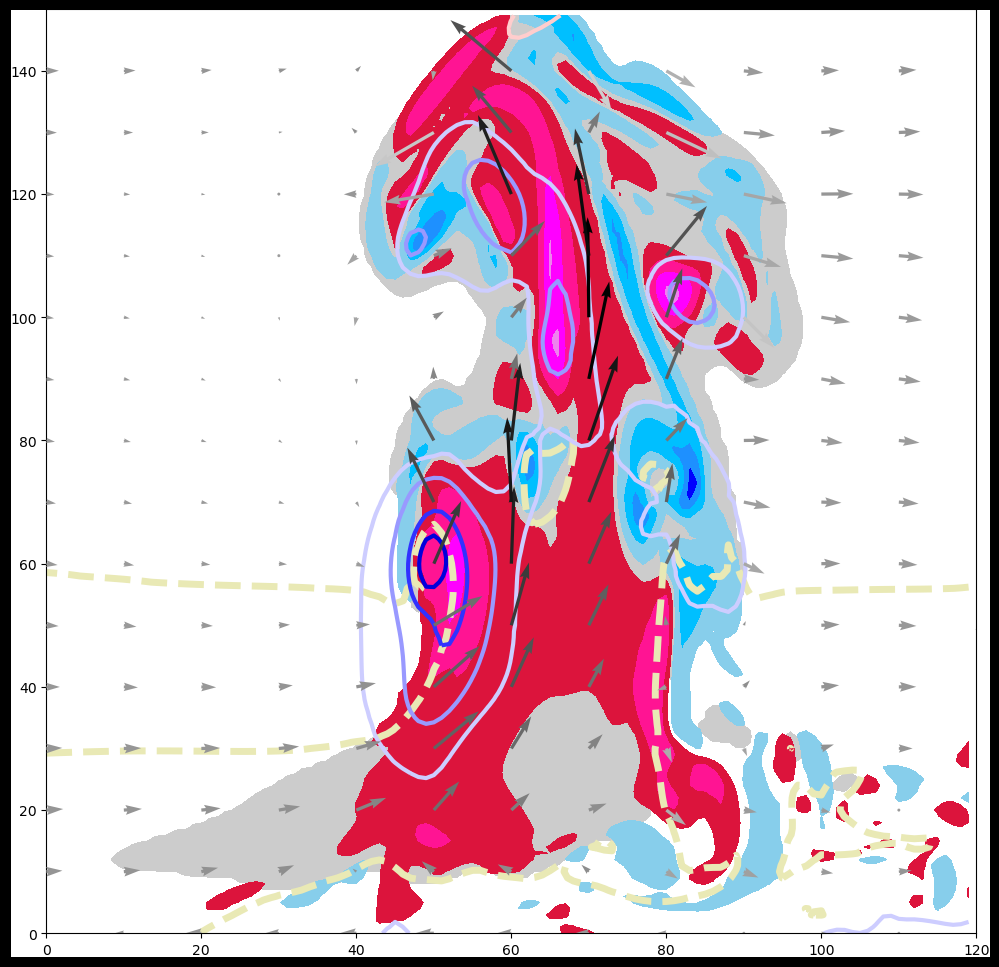

In [44]:
# 7/5/23 This block of code plots the cross section data in the x-z and y-z plane

plt.rcParams["figure.figsize"] = (12,12)
plt.figure(linewidth = 15, edgecolor = "black", facecolor = "white")

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100): # Block of code used to extract specific ranges of colorbars
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

x = 60 # gridpoint value for horizontal "slice" of x-z cross section 
y = 55 # gridpoint value for horizontal "slice" of y-z cross section

fig, (ax1) = plt.subplots(1,1,figsize=(12,12), linewidth = 15, edgecolor = "black") # Set figure size and subplots

omega_h = (xv_cross**2 + yv_cross**2)**0.5 # calculate total horizontal vorticity from x- and y-components
omega = (omega_h**2 + zv_cross**2)**0.5 # calculate total vorticity

x_cross_section = True
if x_cross_section == True:
    # x-z cross section
    plt.contourf(cloud_cross[:,0:120,x], levels=[0.00001,1000], colors=["gray"], linewidths = 8, zorder = 1, alpha = 0.4) # plot cloud
    #im1 = ax1.contour(w_cross[:,0:120,x], levels = [5, 15, 25, 35, 45, 55], cmap = plt.get_cmap("YlOrRd"), zorder = 3)
    im2 = plt.contourf(zv_cross[:,0:120,x], levels = [0.005,0.02,0.04,0.06,0.08,0.1,1], colors = zv_cmap)
    im3 = plt.contourf(zv_cross[:,0:120,x], levels = [-1,-0.1,-0.08,-0.06,-0.04,-0.02,-0.005], colors = neg_zv_cmap)
    #im4 = ax1.contourf((((xv_cross[:,0:120,x]**2)+(yv_cross[:,0:120,x]**2))**0.5), levels = [0.005,0.02,0.04,0.06,0.08,0.1], cmap = truncate_colormap(plt.get_cmap("Oranges"), 0,0.8))
    #im5 = ax1.contourf((((xv_cross[:,0:120,x]**2)+(yv_cross[:,0:120,x]**2))**0.5), levels = [0.1,1], cmap = truncate_colormap(plt.get_cmap("Oranges"), 0.8,1))
    #im4 = plt.contourf(abs(xv_cross[:,0:120,x]), levels = [0.005,0.02,0.04,0.06,0.08,0.1], cmap = truncate_colormap(plt.get_cmap("Oranges"), 0,0.8))
    #im5 = plt.contourf(abs(xv_cross[:,0:120,x]), levels = [0.1,1], cmap = truncate_colormap(plt.get_cmap("Oranges"), 0.8,1))

    # Comparing vertical gradients in vertical and horizontal vorticity (8/4/23)
    #im4 = plt.contourf((omega_h[:,0:120,x]), levels = [0.005,0.02,0.04,0.06,0.08,0.1], cmap = truncate_colormap(plt.get_cmap("Oranges"), 0,0.8))
    #im5 = plt.contourf((omega_h[:,0:120,x]), levels = [0.1,1], cmap = truncate_colormap(plt.get_cmap("Oranges"), 0.8,1))
    #im2 = plt.contourf(abs(zv_cross[:,0:120,x]), levels = [0.005,0.02,0.04,0.06,0.08,0.1,1], colors = zv_cmap)

    # plot buoyancy
    #im11 = ax1.contour(abs(buoy_cross[:,0:120,x]), levels = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4], cmap = plt.get_cmap("YlOrRd"))

    # calculate and plot tilting term
    udir = abs(u_cross[:,:,0:119]/u_cross[:,:,0:119]) # Sign of u wind
    vdir = abs(v_cross[:,0:119]/v_cross[:,0:119]) # Sign of v wind

    dwdx = (w_cross[:,:,1:120] - w_cross[:,:,0:119])/250 # dw/dx, 250 m grid spacing
    dwdy = (w_cross[:,1:120,:] - w_cross[:,0:119,:])/250 # dw/dy, 250 m grid spacing

    tiltx = udir*dwdx*xv_cross[:,:,0:119]
    tilty = vdir*dwdy*yv_cross[:,0:119,:]
    tilting = tiltx[:,0:119,:] + tilty[:,:,0:119]
    #tilting = (tiltx[:,0:119,:] + tilty[:,:,0:119])*(omega_h[:,0:119,0:119])

    #tilting_cmap = ["lime", "darkgreen", "navy", "royalblue"]
    #tilting_widths = abs(tilting[:,0:119,x]/0.0005)
    #im7 = ax1.contour(tilting[:,0:119,x], levels = [0.00005, 0.0005, 0.005, 0.05], colors = tilting_cmap, linewidths = [2,3,4,5], zorder = 3) # plot tilting
    #im7 = plt.contourf(tilting[:,0:119,x], levels = [0.00005, 0.0005, 0.005, 0.05], colors = 'none', hatches = ["x", "xxx", "xxxxx"], linewidths = [2,3,4,5], zorder = 3) # plot tilting


    # Plot passive tracer concentrations
    #im6 = ax1.contour(eil_pta_cross[:,0:120,x], levels = [99], colors = ["black"], linestyles = "--")
    pink_r = plt.get_cmap("pink_r")
    #im8 = ax1.contourf(ml_pta_cross[:,0:120,x], levels = [5, 25, 45, 65, 85], cmap = truncate_colormap(pink_r, 0, 0.85))
    im9 = plt.contour(ml_pta_cross[:,0:120,x], levels = [25], colors = [pink_r(0.25)], linestyles = "--", linewidths = 5, zorder = 2)
    #im9 = ax1.contour(ml_pta_cross[:,0:120,x], levels = [85], colors = [pink_r(0.85)])

    # Plot dynamic pressure perturbations
    #im10 = ax1.contour(pdnl_cross[:,0:120,x]/100, levels = [-15,-12,-9,-6,-3,-1,1,3,6,9,12,15], cmap = plt.get_cmap("seismic"), linewidths = 5)
    im10 = ax1.contour(pdnl_cross[:,0:120,x]/100, levels = [-10,-8,-6,-4,-2,-1,1,2,4,6,8,10], cmap = plt.get_cmap("seismic"), linewidths = 3) # p'NL
    #im10 = ax1.contour(pdl_cross[:,0:120,x]/100, levels = [-0.01,-0.008,-0.006,-0.004,-0.002,-0.001,0.001,0.002,0.004,0.006,0.008,0.01], cmap = plt.get_cmap("seismic"), linewidths = 5) # p"L
    #im10 = ax1.contour(pdl_cross[:,0:120,x]/100, levels = [-0.5,-0.1,-0.08,-0.06,-0.04,-0.02,-0.01,0.01,0.02,0.04,0.06,0.08,0.1,0.5], cmap = plt.get_cmap("seismic"), linewidths = 5) # p"L


    # Plot SR wind vectors
    k = 10 # Number of gridpoints between each plotted arrow
    y,z = np.meshgrid(np.arange(0,200,k),np.arange(0,150,k))
    w_arrow_cross = w_cross[::k,::k,x]/70
    g = plt.get_cmap("Greys")
    g = truncate_colormap(g, 0.3,1)
    ax1.quiver(y,z,v_cross[::k,::k,x],w_cross[::k,::k,x],w_arrow_cross,scale=500,width=0.0035,zorder=50,color="black", cmap = g)
    #ax1.quiver(50,50, 30, 0, scale = 500, width = 0.0035, zorder = 50, cmap = g) # reference vector

    # Colorbars
    #plt.colorbar(im7, ax = ax1) # tilting
    #plt.colorbar(im10, ax = ax1) # p' dnl
    #plt.colorbar(im4, ax = ax1) # x-vort
    #plt.colorbar(im5, ax = ax1) # x-vort
    #plt.colorbar(im11, ax = ax1) # buoyancy

    # Plot limits and axes specifications
    ax1.set_xlim([0,120]) # standard
    ax1.set_ylim([0,150]) # standard

    #ax1.set_xlim([20,92]) # zoom in on midlevel updraft
    #ax1.set_ylim([20,110]) # zoom in on midlevel updraft

    #ax1.set_xticks([]) # Turns off x-ticks
    #ax1.set_yticks([]) # Turns off y-ticks
    #plt.axis("off")

h5_plot = False # Plot the H5-moist figure?
plot_a = True # Plot the (a) figure?
plot_b = False # Plot the (b) figure?
if h5_plot == True:
    if plot_a == True:
        plt.contourf(cloud_cross[:,0:120,x], levels=[0.00001,1000], colors=["gray"], linewidths = 8, zorder = 1, alpha = 0.4) # plot cloud
        zv_cmap = ["crimson","deeppink","fuchsia","violet","thistle","gainsboro","whitesmoke"]
        neg_zv_cmap = ["midnightblue","mediumblue","blue","dodgerblue","deepskyblue","skyblue","lightskyblue"]
        pink_r = plt.get_cmap("pink_r")
        im2 = plt.contourf(zv_cross[:,0:120,x], levels = [0.005,0.02,0.04,0.06,0.08,0.1,1], colors = zv_cmap)
        im3 = plt.contourf(zv_cross[:,0:120,x], levels = [-1,-0.1,-0.08,-0.06,-0.04,-0.02,-0.005], colors = neg_zv_cmap)
        im9 = plt.contour(ml_pta_cross[:,0:120,x], levels = [25], colors = [pink_r(0.25)], linestyles = "--", linewidths = 5, zorder = 2)
        im10 = ax1.contour(pdnl_cross[:,0:120,x]/100, levels = [-10,-8,-6,-4,-2,-1,1,2,4,6,8,10], cmap = plt.get_cmap("seismic"), linewidths = 3) # p'NL
        
        k = 10 # Number of gridpoints between each plotted arrow
        y,z = np.meshgrid(np.arange(0,200,k),np.arange(0,150,k))
        w_arrow_cross = w_cross[::k,::k,x]/70
        g = plt.get_cmap("Greys")
        g = truncate_colormap(g, 0.3,1)
        ax1.quiver(y,z,v_cross[::k,::k,x],w_cross[::k,::k,x],w_arrow_cross,scale=500,width=0.0035,zorder=50,color="black", cmap = g)

        ax1.set_xlim([0,119]) # standard
        ax1.set_ylim([0,149]) # standard
        ax1.set_xticks([]) # Turns off x-ticks
        ax1.set_yticks([]) # Turns off y-ticks
        plt.axis("off")

    if plot_b == True:
        #plt.contourf(cloud_cross[:,0:120,x], levels=[0.00001,1000], colors=["gray"], linewidths = 8, zorder = 1, alpha = 0.4) # plot cloud
        #im2 = plt.contourf((zv_cross[:,0:120,x]), levels = [0.005,0.02,0.04,0.06,0.08,0.1], cmap = plt.get_cmap("Greys")) # sanity check...
        #plt.colorbar()
        g = plt.get_cmap("Greys")
        im4 = plt.contour(omega[:,0:120,x], colors = [g(0.35),g(0.5),g(0.65),g(0.8),g(0.95)], linewidths = [2], levels = [0.02,0.04,0.06,0.08,0.1])
        o_h = (((xv_cross[:,0:120,x])**2 + (yv_cross[:,0:120,x])**2)**0.5)**2
        reds = plt.get_cmap("Reds")
        #plt.contourf(1 - (o_h/((omega[:,0:120,x])**2)), cmap = reds, zorder = 1, levels = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
        plt.contourf(1 - (o_h/((omega[:,0:120,x])**2)), cmap = reds, zorder = 1, levels = [0.1,0.3,0.5,0.7,0.9,1], linewidths = 3)
        s = plt.get_cmap("seismic")
        im11 = ax1.contour(pdnl_cross[:,0:120,x]/100, levels = [-4], colors = [s(0.3)], linewidths = 5, linestyles = "-", zorder = 3)

        k = 10 # Number of gridpoints between each plotted arrow
        y,z = np.meshgrid(np.arange(0,200,k),np.arange(0,150,k))
        w_arrow_cross = w_cross[::k,::k,x]/70
        g = plt.get_cmap("Greys")
        g = truncate_colormap(g, 0.3,1)
        #ax1.quiver(y,z,v_cross[::k,::k,x],w_cross[::k,::k,x],w_arrow_cross,scale=500,width=0.0035,zorder=50,color="black", cmap = g)


        ax1.set_xlim([0,119]) # standard
        ax1.set_ylim([0,149]) # standard
        ax1.set_xticks([]) # Turns off x-ticks
        ax1.set_yticks([]) # Turns off y-ticks
        plt.axis("off")


y_cross_section = False
if y_cross_section == True:

    # y-z cross section
    ax1.contourf(cloud_cross[:,y,0:120], levels=[0.00001,1000], colors=["gray"], linewidths = 8, zorder = 1, alpha = 0.4) # plot cloud
    cloud_depth = False
    if cloud_depth == True:
        alph = 0.4
        cloud_color = "silver"
        ax1.contourf(cloud_cross[:,y,0:120], levels=[0.00001,1000], colors=[cloud_color], linewidths = 8, zorder = 1, alpha = 0.4) # plot cloud
        ax1.contourf(cloud_cross[:,y+1,0:120], levels=[0.00001,1000], colors=[cloud_color], linewidths = 8, zorder = 1, alpha = 0.4) # plot cloud
        ax1.contourf(cloud_cross[:,y+3,0:120], levels=[0.00001,1000], colors=[cloud_color], linewidths = 8, zorder = 0.9, alpha = alph) # plot cloud
        ax1.contourf(cloud_cross[:,y+5,0:120], levels=[0.00001,1000], colors=[cloud_color], linewidths = 8, zorder = 0.8, alpha = alph) # plot cloud
        ax1.contourf(cloud_cross[:,y+7,0:120], levels=[0.00001,1000], colors=[cloud_color], linewidths = 8, zorder = 0.8, alpha = alph) # plot cloud
        ax1.contourf(cloud_cross[:,y+9,0:120], levels=[0.00001,1000], colors=[cloud_color], linewidths = 8, zorder = 0.8, alpha = alph) # plot cloud
        ax1.contourf(cloud_cross[:,y+11,0:120], levels=[0.00001,1000], colors=[cloud_color], linewidths = 8, zorder = 0.7, alpha = alph) # plot cloud
        ax1.contourf(cloud_cross[:,y+13,0:120], levels=[0.00001,1000], colors=[cloud_color], linewidths = 8, zorder = 0.8, alpha = alph) # plot cloud
        ax1.contourf(cloud_cross[:,y+15,0:120], levels=[0.00001,1000], colors=[cloud_color], linewidths = 8, zorder = 0.6, alpha = alph) # plot cloud
        ax1.contourf(cloud_cross[:,y+17,0:120], levels=[0.00001,1000], colors=[cloud_color], linewidths = 8, zorder = 0.5, alpha = alph) # plot cloud
        ax1.contourf(cloud_cross[:,y+19,0:120], levels=[0.00001,1000], colors=[cloud_color], linewidths = 8, zorder = 0.5, alpha = alph) # plot cloud
        ax1.contourf(cloud_cross[:,y+21,0:120], levels=[0.00001,1000], colors=[cloud_color], linewidths = 8, zorder = 0.5, alpha = alph) # plot cloud
        ax1.contourf(cloud_cross[:,y+23,0:120], levels=[0.00001,1000], colors=[cloud_color], linewidths = 8, zorder = 0.5, alpha = alph) # plot cloud
        ax1.contourf(cloud_cross[:,y+25,0:120], levels=[0.00001,1000], colors=[cloud_color], linewidths = 8, zorder = 0.5, alpha = alph) # plot cloud


    #im2 = ax1.contour(w_cross[:,y,0:120], levels = [5, 15, 25, 35, 45, 55], cmap = plt.get_cmap("YlOrRd")) 

    im4 = ax1.contourf(abs(xv_cross[:,y,0:120]), levels = [0.02,0.04,0.06,0.08,0.1], cmap = truncate_colormap(plt.get_cmap("Oranges"), 0,0.8))
    im5 = ax1.contourf(abs(xv_cross[:,y,0:120]), levels = [0.1,1], cmap = truncate_colormap(plt.get_cmap("Oranges"), 0.8,1))

    im2 = ax1.contour(zv_cross[:,y,0:120], levels = [0.04], colors = ["deeppink"], linestyles = "--", linewidths = 5, zorder = 3)
    #im2 = ax1.contour(zv_cross[:,y,0:120], levels = [0.08], colors = ["deeppink"], linestyles = "--", linewidths = 5)
    im3 = ax1.contour(zv_cross[:,y,0:120], levels = [-0.04], colors = ["mediumblue"], linestyles = "--", linewidths = 5, zorder = 3)

    s = plt.get_cmap("seismic")
    im10 = ax1.contour(pdnl_cross[:,y,0:120]/100, levels = [-10,-8,-6,-4,-2,-1,1,2,4,6,8,10], cmap = s, linewidths = 5)
    #im11 = ax1.contour(pdnl_cross[:,y,0:120]/100, levels = [-4], colors = [s(0.3)], linewidths = 5, linestyles = "-")
    # pdl_lvls = [-1,-0.5,-0.1,-0.08,-0.06,-0.04,-0.02,-0.01,0.01,0.02,0.04,0.06,0.08,0.1,0.5,1]
    #im10 = ax1.contour(-pdl_cross[:,y,0:120]/100, levels = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4, 0.5], cmap = plt.get_cmap("seismic"), linewidths = 5) # p"L
    plt.colorbar(im10, ax = ax1) # p' dl

    #im7 = plt.contourf(tilting[:,y,0:119], levels = [0.00005, 0.0005, 0.005, 0.05], colors = 'none', hatches = ["x", "xxx", "xxxxx"], linewidths = [2,3,4,5], zorder = 3) # plot tilting



    k = 4 # Number of gridpoints between each plotted arrow
    b,z = np.meshgrid(np.arange(0,200,k),np.arange(0,150,k))
    # Shade arrows by w
    #w_arrow_cross = w_cross[::k,y,::k]/70
    #g = plt.get_cmap("Greys")
    #g = truncate_colormap(g, 0.3,1)

    # Shade arrows by perpedicularity to the y-z plane
    v_arrow_cross = v_cross[::k,y,::k]/70 + 0.0327
    print("MAX", np.amax(v_arrow_cross))
    print("MIN", np.amin(v_arrow_cross))

    g = plt.get_cmap("PRGn_r")
    #g = truncate_colormap(g, 0.3,1)
    ax1.quiver(b,z,u_cross[::k,y,::k],w_cross[::k,y,::k],v_arrow_cross,scale=500,width=0.0035,zorder=50,color="black", cmap = g)
    #plt.colorbar()
    #lvls = np.linspace(-4770,4770,1000)
    #plt.contourf((v_cross[:,y,0:120]/70 - 0.0654), levels = lvls, cmap = plt.get_cmap("PRGn_r"))
    #plt.colorbar()
    #ax1.contour(v_cross[:,y,0:120], levels = [0], colors = ["black"], linewidths = 5)
    #ax1.quiver(b,z,30,0,scale=500,width=0.0035,zorder=50,color="black", cmap = g) # Reference vector

    ax1.set_xlim([0,120]) # standard
    ax1.set_ylim([0,150]) # standard

    #ax1.set_xlim([20,92]) # zoom in on midlevel updraft
    #ax1.set_ylim([20,110]) # zoom in on midlevel updraft

    #ax1.set_xlim([44,76]) # zoom in on midlevel updraft (1x1 aspect ratio)
    #ax1.set_ylim([20,100]) # zoom in on midlevel updraft (1x1 aspect ratio)

    #ax1.set_xticks([]) # Turns off x-ticks
    #ax1.set_yticks([]) # Turns off y-ticks
    #ax1.axis("off")


SpearmanrResult(correlation=-0.49090909090909085, pvalue=0.14965567342083677)
PearsonRResult(statistic=-0.4798898679470852, pvalue=0.16042140421258838)


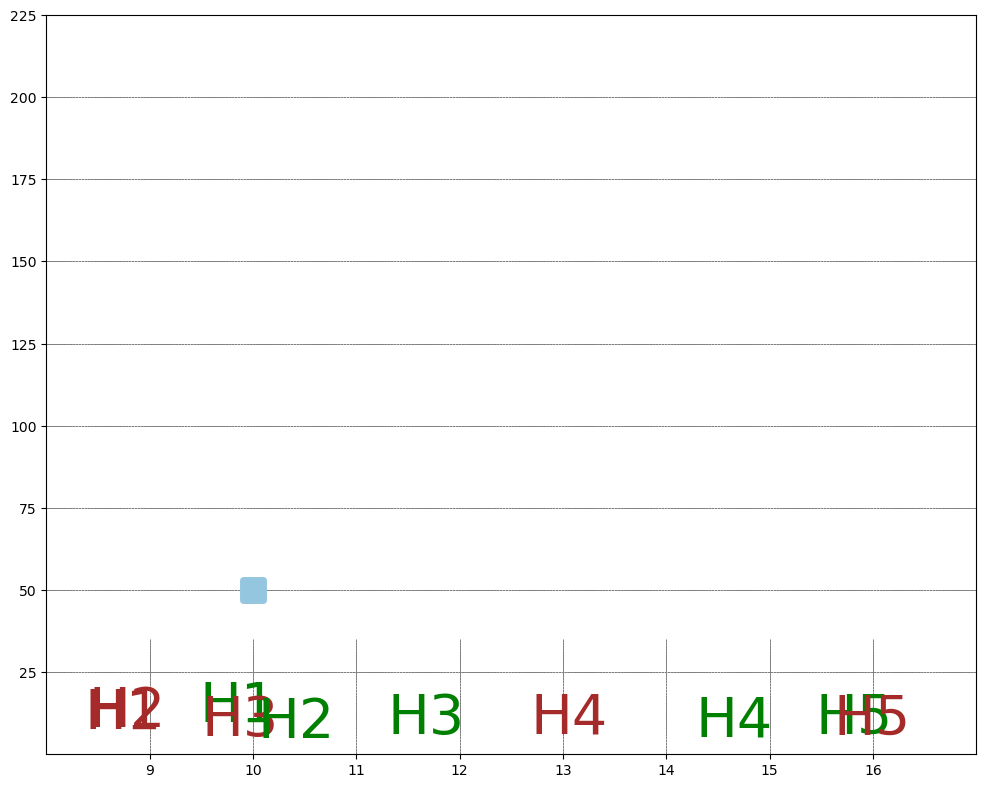

In [7]:
# This code is for creating scatterplots of updraft characteristics
x = [0,5,10,20,30] # x-values (MLS in m/s of H1-H5) to plot data against
srf_dry = [8.742, 8.766, 9.869, 13.054, 15.989] # Sequential values of 0-1 km SR flow to plot data against (starting with H1-dry)
srf_moist = [9.852, 10.413, 11.673, 14.654, 15.812]

labels = ["H1", "H2", "H3", "H4", "H5"]

# List of average zeta for H1-H5 dry
zv_dry = [[0.01013197478231378, 0.007198194946390645, 0.009345199443942031, 0.011180371938081012, 0.01039430171213255, 0.008270918008114253, 0.008144796326223981, 0.009219349985600696, 0.007032027615990984, 0.009662839807300297, 0.009791485698818504, 0.006841317683879133, 0.005583381384789007],
          [0.007107159776885907, 0.005103616024680402, 0.0070665868867414525, 0.0062573399054967815, 0.006094369421060382, 0.00608168766181013, 0.007717056565164392, 0.006845477636887342, 0.010635056698565723, 0.010498549636275372, 0.010405479923963104, 0.009044046486295728, 0.008622839558891558],
          [0.005676408068410475, 0.004187404886197526, 0.00509270236098527, 0.004125587073801917, 0.004127225580658364, 0.007582063589929322, 0.009289951572315361, 0.006803376947540136, 0.007541658451284373, 0.008597838669104034, 0.008842149273871542, 0.008454260756483142, 0.006897339493378981],
          [0.008123108320950433, 0.008492279424094492, 0.006837865797077499, 0.006453070329751445, 0.006030690529574477, 0.004973566051970439, 0.00446518359820922, 0.005070857357746844, 0.0052659484843631706, 0.0053842407489636465, 0.005897353457278603, 0.005904950019440672, 0.005447035358930961],
          [0.002202972306295783, 0.005550748171492438, 0.006322108256556325, 0.0058401308270201015, 0.0038745338691978395, 0.003587594226090504, 0.004210666904699319, 0.005349271744727645, 0.005465238139653295, 0.003978269700903236, 0.004398352755819191, 0.004840918892091622, 0.004530729640828538]]
# List of average zeta for H1-H5 moist
zv_moist = [[0.0071680599371846685, 0.005299539367886247, 0.00627781360983744, 0.006915041133176944, 0.007050053802322936, 0.007600944926033443, 0.003826151117001924, 0.002300585797291986, 0.005163676955899228, 0.007175196786341866, 0.008615460652293431, 0.008725445734611915, 0.007626482619546248],
            [0.006729967556563925, 0.008513187922667208, 0.008733081333478544, 0.011429369279977905, 0.011230478809192639, 0.008483680192841042, 0.006639578997313382, 0.008209451118534952, 0.006754946428391997, 0.006959826012135745, 0.007647500493575739, 0.00955190009178174, 0.011267720248379465],
            [0.006714794128084715, 0.005312851425752958, 0.005135181519463447, 0.006034495807728138, 0.006605005872385946, 0.007752889306383366, 0.008257833327677605, 0.007170280713791498, 0.007370012337261573, 0.006201590890030794, 0.007166084425106292, 0.007297322624574043, 0.006905572057410499],
            [0.005303346353863441, 0.006112406736479759, 0.004850629267467112, 0.005112731465606633, 0.005702597736864858, 0.006359449489665907, 0.005926074226626298, 0.0052447840984153485, 0.005189017085177283, 0.005186120464522805, 0.00565811052766654, 0.0057385328855958165, 0.005331362553304549],
            [0.007018419138541702, 0.00584947624832042, 0.0040557221985704234, 0.003391490963041529, 0.004426061109171, 0.0032851358639384605, 0.004396558780294975, 0.003307210554067397, 0.002956627227008049, 0.003234868517726155, 0.004152753045894082, 0.005222030624614015, 0.004444102322348747]]

# List of average circulaton for H1-H5 dry
circ_dry = [[146913.6343435498, 100774.72924946903, 150107.26606831886, 168404.35231734524, 128629.48368764031, 89946.2333382425, 113009.04902635774, 135985.41228761026, 87460.84347388786, 115350.1501996473, 97302.88913200889, 83378.55927227694, 51646.27780929831],
            [178123.19190820304, 106856.96051674591, 140890.07605440772, 127493.30057449693, 123030.08268765647, 139878.816221633, 171704.50857490773, 150600.50801152154, 161519.92360946693, 156822.08519186336, 189900.00861232667, 175228.40067197973, 164911.80656380104],
            [124526.2020007548, 99450.86604719126, 130500.49800024753, 88184.42370251597, 109371.47788744666, 226514.1497491385, 242119.3628534691, 165407.10203706953, 167801.9005410773, 207422.85789213484, 175185.08248857994, 164858.08475142127, 117254.77138744267],
            [221862.39601595871, 318460.4784035435, 288045.09670188965, 260542.71456371457, 312088.2349054792, 302144.1376572042, 250329.3554746044, 329922.6568384041, 344261.3821652423, 317670.20418885513, 353472.6228456363, 359094.77305723587, 307757.4977795993],
            [109322.50069992823, 270598.97336025635, 328749.62934092886, 375593.4138127303, 297854.79119458393, 304721.2845785622, 380802.1881937447, 482437.4454776245, 525346.016174173, 424928.9324277269, 497838.5525492847, 522214.1254843838, 420508.34478939866]]
# List of average circulation for H1-H5 moist
circ_moist = [[155905.30363376654, 95391.70862195245, 142820.25962380177, 137868.63259271532, 133069.7655188454, 142517.71736312704, 85131.86235329282, 55789.20558433066, 121023.67865388814, 160545.02809439925, 161539.88723050183, 225770.9083830833, 180652.30705050175],
              [218723.94558832757, 211233.47533118012, 213414.6750868819, 254303.4664795084, 273742.92097407056, 246556.95560444277, 180098.58030212548, 201644.64309901476, 160007.79352253542, 158771.03090184668, 167767.04207781778, 192828.9831028439, 190847.01170692718],
              [235017.79448296502, 245055.27201285516, 250981.99676377597, 270043.6873958342, 267089.9249646067, 282011.34851969493, 283863.0206389177, 264852.2438656735, 282363.59767133405, 242637.2435724548, 236480.78602850763, 225760.91869775945, 210619.9477510202],
              [317869.32208469, 357575.7940840659, 328933.29720011353, 408059.8800987294, 453356.5200807562, 442776.6707179888, 418528.9922554823, 365168.09285216866, 408635.0954577111, 441144.37201347115, 461136.008004823, 465179.8220386109, 426842.21442394546],
              [288193.8358763686, 274194.19914001966, 257031.3943344006, 227017.92633859234, 300418.8977849816, 240841.5230249884, 311331.31862963794, 272638.17005093105, 276444.6457252526, 346535.28996141435, 435260.4286227735, 575728.8763636951, 487740.22987777495]]

# List of average vrot for H1-H5 dry
vrot_dry = [[10.883614969300254, 7.5977096043549235, 10.56550385444202, 12.240519481456527, 10.314851752988973, 7.694199032169676, 8.558384468997009, 9.988295450376757, 6.995877278400302, 9.417953461354248, 8.707274435571177, 6.737397020560156, 4.790305691514671],
            [10.036986544717001, 6.5877251670938035, 8.901027060373224, 7.967711925146204, 7.724406382865765, 8.227788099687409, 10.268612352527663, 9.05753799320974, 11.691709688585673, 11.446252789057095, 12.539742487053669, 11.229972933511654, 10.637659756101455],
            [7.500016927212007, 5.756676576284966, 7.272358836677339, 5.380639398993306, 5.993440684671452, 11.690590478869948, 13.378781291694073, 9.46312139709298, 10.03522087436632, 11.912914386800821, 11.102545206991227, 10.53144617343542, 8.022341245278975],
            [11.975620904493908, 14.670164283502249, 12.519460025988478, 11.56692005652946, 12.238192718374975, 10.935435897485304, 9.431279574500518, 11.53830023728418, 12.010954592181632, 11.666633213968973, 12.879575171458619, 12.98995728000266, 11.549933569843214],
            [4.377784361467249, 10.932862913416956, 12.860524112603926, 13.211901891489584, 9.58312369784445, 9.327131964734201, 11.295884134996669, 14.330551459159679, 15.115493638157025, 11.598460029273028, 13.200316960836354, 14.183495610209425, 12.313072909718214]]
# List of average vrot for H1-H5 moist
vrot_moist = [[9.43031775908075, 6.342630961505121, 8.446838402242832, 8.71014101100005, 8.640342924924695, 9.284601959239236, 5.091223874143848, 3.195871978103243, 7.051958942815233, 9.574374403980118, 10.52383928977835, 12.520534496234715, 10.47077835359122],
              [10.823051353055684, 11.962516513117043, 12.17842035454008, 15.208358469182894, 15.641040943846422, 12.901667400319594, 9.754847489861357, 11.477451681950303, 9.27420284952848, 9.377344944228584, 10.10434458929612, 12.106709150660123, 13.08144675972269],
              [11.206288324105886, 10.178667518758738, 10.12731347126051, 11.387609806182738, 11.84841957752776, 13.190466408576201, 13.657856156010192, 12.293200800601939, 12.868665989900562, 10.942721753814874, 11.612720096879404, 11.449887605091979, 10.758324732309985],
              [11.582288312829933, 13.188191560701338, 11.268030883052766, 12.88497286547813, 14.343375552908036, 14.969151862517759, 14.048869724770572, 12.34540344771606, 12.989889295041062, 13.492944677635208, 14.409380153851433, 14.574911940079879, 13.456987802727392],
              [12.686945144285406, 11.297508850367855, 9.107983894666173, 7.82745313854878, 10.286494425806332, 7.934826191366594, 10.436693163099012, 8.470700364720821, 8.064871375722058, 9.444894665010569, 11.9932728307883, 15.467630237716707, 13.1335273298658]]

# List of minimum p'NL where x-vorticity exceeds 0.04 1/s for H1-H5 dry
pnl_dry = [[-421.91015625, -345.49609375, -461.828125, -256.69140625, -202.76171875, -206.29296875, -332.01171875, -466.65234375, -194.64453125, -234.4453125, -223.75, -334.88671875, -171.2265625],
           [-560.94140625, -250.37890625, -265.73828125, -428.7578125, -268.8359375, -255.1171875, -247.3984375, -332.7734375, -413.421875, -504.12109375, -377.515625, -383.30078125, -286.08203125],
           [-351.83984375, -323.08203125, -248.6171875, -351.51171875, -456.00390625, -606.3359375, -541.05859375, -375.3203125, -481.77734375, -572.76953125, -503.734375, -283.86328125, -568.0390625],
           [-642.359375, -738.76953125, -599.2421875, -494.20703125, -441.60546875, -651.671875, -638.15625, -609.609375, -504.64453125, -359.6953125, -444.640625, -444.421875, -672.171875],
           [-420.86328125, -697.5859375, -734.59765625, -607.88671875, -440.046875, -667.3984375, -546.578125, -540.1015625, -628.53125, -870.25, -940.73828125, -876.73046875, -630.66015625]]

# List of minimum p'NL where x-vorticity exceeds 0.04 1/s for H1-H5 moist
pnl_moist = [[-309.375, -350.4140625, -384.90234375, -282.25390625, -303.8125, -373.515625, -265.4921875, -482.29296875, -235.48828125, -262.34765625, -289.10546875, -350.70703125, -317.9296875],
             [-552.62890625, -488.19140625, -352.76171875, -394.125, -345.7578125, -439.03515625, -346.90234375, -309.64453125, -300.390625, -295.99609375, -261.33203125, -303.8125, -410.63671875],
             [-433.7421875, -582.8359375, -505.75, -570.87890625, -512.87890625, -504.23046875, -579.5390625, -651.67578125, -475.73828125, -397.31640625, -412.8203125, -382.37890625, -266.70703125],
             [-752.6953125, -962.6953125, -648.8046875, -607.4921875, -640.2265625, -474.69140625, -460.86328125, -507.50390625, -693.671875, -573.796875, -474.9296875, -896.3828125, -630.73046875],
             [-412.265625, -567.82421875, -612.61328125, -648.23046875, -570.66015625, -822.23828125, -736.609375, -1032.66015625, -793.78125, -1018.46875, -662.9765625, -648.20703125, -675.8984375]]


#fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(15,45)) # Set figure size and subplots

#ax1.scatter(x, circ_dry, color = "brown")
#ax1.scatter(x, circ_moist, color = "green")

#ax2.scatter(x, zv_dry, color = "brown")
#ax2.scatter(x, zv_moist, color = "green")

plt.rcParams["figure.figsize"] = (12,9.6)

vrot_plot = False # Plot vrot?
circ_plot = False # Plot circulation?
zv_plot = False # Plot average zeta?
pnl_plot = False # Plot rotor minimum p'NL?

avg_plot = True # Make a scatterplot of 1-hr time-averaged updraft characteristics?

if vrot_plot == True:
    if avg_plot == True:
        for a in range(0,5):
            avg_dry = float(sum(vrot_dry[a])/len(vrot_dry[a]))
            print("AVG DRY:", avg_dry)
            avg_moist = float(sum(vrot_moist[a])/len(vrot_moist[a]))
            print("AVG MOIST:", avg_moist)
            plt.text(x[a]-1.35, avg_dry-1, labels[a], color = "brown", size = 40)
            plt.text(x[a]-1.35, avg_moist-1, labels[a], color = "green", size = 40)
        for b in range(0, 20, 5):
            plt.hlines(b, -5, 35, linestyles = "--", color = "gray", linewidths = 0.5)

    plt.xlim([-2,32]) # x-limits
    plt.ylim([0,20]) # y-limits

    plt.xticks([0,5,10,20,30]) # Sets x-ticks
    plt.yticks([0,5,10,15,20]) # Sets y-ticks

if circ_plot == True:
    if avg_plot == True:
        for a in range(0,5):
            avg_dry = float(sum(circ_dry[a])/len(circ_dry[a]))
            print("AVG DRY:", avg_dry)
            avg_moist = float(sum(circ_moist[a])/len(circ_moist[a]))
            plt.text(x[a]-1.35, avg_dry-1, labels[a], color = "brown", size = 40)
            plt.text(x[a]-1.35, avg_moist-1, labels[a], color = "green", size = 40)
        for b in range(0, 500000, 100000):
            plt.hlines(b, -5, 35, linestyles = "--", color = "gray", linewidths = 0.5)

    plt.xlim([-2,32]) # x-limits
    plt.ylim([0,500000]) # y-limits

    plt.xticks([0,5,10,20,30]) # Sets x-ticks
    plt.yticks([0,100000,200000,300000,400000,500000]) # Sets y-ticks

if zv_plot == True:
    if avg_plot == True:
        for a in range(0,5):
            avg_dry = float(sum(zv_dry[a])/len(zv_dry[a]))
            print("AVG DRY:", avg_dry)
            avg_moist = float(sum(zv_moist[a])/len(zv_moist[a]))
            plt.text(x[a]-1.35, avg_dry-1, labels[a], color = "brown", size = 40)
            plt.text(x[a]-1.35, avg_moist-1, labels[a], color = "green", size = 40)
        #for b in range(0, 0.01, 0.001):
        #    plt.hlines(b, -5, 35, linestyles = "--", color = "gray", linewidths = 0.5)

    plt.xlim([-2,32]) # x-limits
    plt.ylim([0,1]) # y-limits

    plt.xticks([0,5,10,20,30]) # Sets x-ticks
    #plt.yticks([0,0.002,0.004,0.006,0.008,0.01]) # Sets y-ticks


if pnl_plot == True:
    if avg_plot == True:
        for a in range(0,5):
            avg_dry = float(sum(pnl_dry[a])/len(pnl_dry[a]))/100
            print("AVG DRY:", avg_dry)
            avg_moist = float(sum(pnl_moist[a])/len(pnl_moist[a]))/100
            print("AVG MOIST:", avg_moist)
            plt.text(srf_dry[a]-0.37, avg_dry-0.12, labels[a], color = "brown", size = 40)
            plt.text(srf_moist[a]-0.37, avg_moist-0.12, labels[a], color = "green", size = 40)
        for b in range(-10, 0, 1):
            plt.hlines(b, 8, 17, linestyles = "--", color = "gray", linewidths = 0.5)
        for c in range(9, 17, 1):
            plt.vlines(c, -11, 1, linestyles = "--", color = "gray", linewidths = 0.5)

    plt.xlim([8,17]) # x-limits
    plt.ylim([-9,-1]) # y-limits

    plt.xticks([9,10,11,12,13,14,15,16]) # Sets x-ticks
    plt.yticks([-9,-8,-7,-6,-5,-4,-3,-2,-1]) # Sets y-ticks


# Spearman rank correlation coefficient calculations (7/11/23)
x = [8.742, 8.776, 9.852, 9.869, 10.413, 11.673, 13.054, 14.654, 15.812, 15.989] # Sequential values of 0-1 km SR flow (m/s)
#x = [0, 0, 5, 5, 10, 10, 20, 20, 30, 30] # Sequential values of 3-6 km shear (m/s)
#y = [-2.9635366586538465, -3.5187560096153847, -3.236643629807692, -4.356887019230769, -3.6932421875, -4.828070913461539, 
#     -5.570150240384615, -6.403449519230769, -7.078795072115384, -6.616899038461538] # Corresponding mean minimum near-updraft rotor p'NL
#y = [8.807068192422053, 8.40641956589534, 9.716702552302335, 11.837800192254567, 9.080007190643757, 11.655549403155446, 
#     11.997879040431858, 13.350338313793042, 11.717738744915904, 10.473292431689572] # Sequential values of midlevel vrot


# Sequential list of (75th percentile vrot, mlpta > 10% and w > 10 m/s vrot)
vrot = [15.58605089294794 , 6.564130114043125, 12.837684290634114, 3.962630147571949, 17.970913975646653 , 5.130025119062971, 18.404405603485603 , 3.9350357728804717, 15.182452233073175 , 6.284887787456775, 18.852573181795794 , 1.6823673985117082, 22.607700200388454 , 4.277976284117386, 25.5192011749063 , 2.7805194927869037, 17.436937576340743 , -0.8977109193555588, 22.392939421999777 , 3.939833015169152]

#y = [vrot[0], vrot[2], vrot[4], vrot[6], vrot[8], vrot[10], vrot[12], vrot[14], vrot[16], vrot[18]] # 75th percentile w vrot
#y = [vrot[1], vrot[3], vrot[5], vrot[7], vrot[9], vrot[11], vrot[13], vrot[15], vrot[17], vrot[19]] # 

# The following four lists are sequential beginning at H1-dry
# 6-km total updraft vrot:
#y = [20.41360153318558, 20.42493224491002, ]

# 6-km updraft EIL trac. conc. > 99% vrot:
#y = [3.655512332741109, 3.575497795645922, 5.342639583863625, 6.823297625934126, 3.3345687789884235, 8.246221653428629,
#     6.887812561916437, 9.670697831528145, 7.971237690253805, 9.845963769858914]

# 6-km updraft EIL trac. conc. < 99% vrot:
#y = [7.8313270472926755, 7.502234368644145, 8.384664407646158, 10.974029339128727, 8.042795813358147, 9.473737330717428,
#     8.512768451644652, 10.088171294402553, 6.681101196094493, 5.205041997915488]

# 6-km full-updraft vrot
#y = [8.590050872890346, 8.408525540580666, 9.80469609592004, 13.008636260479502, 8.733538261529706, 12.476541646892741, 
#     10.757481360291415, 13.965109484177251, 9.984590803277474, 10.126675674514233]

# Standard deviation in location of horizontal rotor
y = [8.020, 8.499, 10.069, 5.965, 5.203, 6.432, 6.753, 5.640, 6.564, 6.251]

# midlevel updraft area
#y = [27.5625, 35.3125, 44.375, 42.5625, 35.25, 64.125, 99.75, 132.1875, 198.25, 167.6875]



#plt.scatter(x,y)

labels = ["H1", "H2", "H1", "H3", "H2", "H3", "H4", "H4", "H5", "H5"] # sequential
colors = ["brown", "brown", "green", "brown", "green", "green", "brown", "green", "green", "brown"] # sequential

yplot = True # Create a scatterplot of the data in the generic, sequential y lists above?
if yplot == True:
    for d in range(0,10):
        plt.text(x[d]-0.37, y[d]-0.16, labels[d], color = colors[d], size = 40)
        #plt.scatter(x[d], y[d], marker = "o", s = 40, color = colors[d])
        for b in range(0, 225, 25):
            plt.hlines(b, -5, 35, linestyles = "--", color = "gray", linewidths = 0.4)
        for cc in range(8, 17, 1):
            plt.vlines(cc, -5, 35, linestyles = "--", color = "gray", linewidths = 0.4)
    plt.xlim([8,17]) # x-limits
    plt.ylim([0,225]) # y-limits

    plt.xticks([9,10,11,12,13,14,15,16]) # Sets x-ticks
    plt.yticks([25,50,75,100,125,150,175,200,225]) # Sets y-ticks



cmap = plt.get_cmap("RdYlBu")
plt.scatter(10,50, marker = "s", s = 200, lw = 5, color = cmap(0.5 - (-0.4798898679470852/2)), zorder = 10)

spearman = stats.spearmanr(x, y)
print(spearman)

pearson = pearsonr(x,y)
print(pearson)

-9.749979e-06
-9.749979e-06
-9.749977e-06


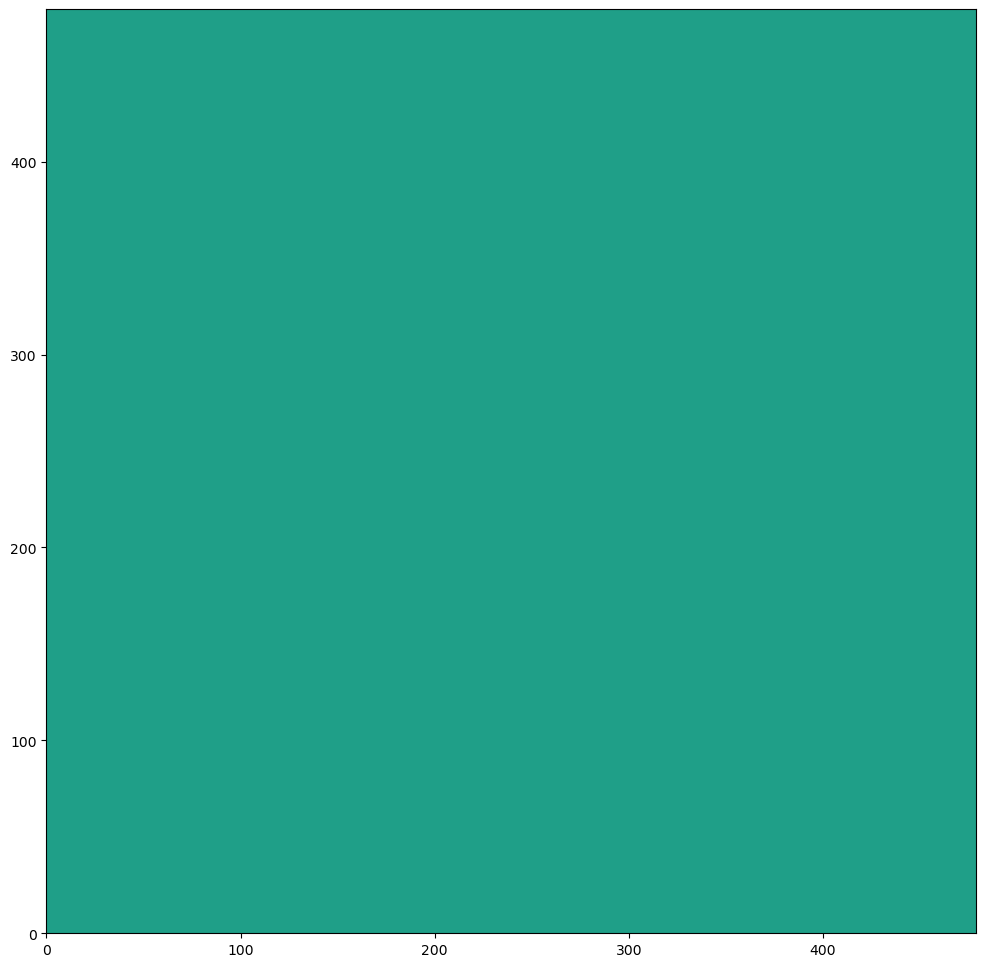

In [124]:
# 8/4/23 - calculating the vertical gradient in horizontal vorticity at t = 0

folder = "/glade/scratch/amuehr/"
#sim = "H5_14_moist_Mor/"
#sim = "H5_14_dry_Mor/"
#sim = "H4_14_moist_Mor/"
sim = "H4_14_dry_Mor/"
#sim = "H3_14_moist_Mor/"
#sim = "H3_14_dry_Mor/"
#sim = "H2_14_moist_Mor/"
#sim = "H2_14_dry_Mor/"
#sim = "H1_14_moist_Mor/"
#sim = "H1_14_dry_Mor/"

file = folder + sim + 'cm1out_000001.nc' # first output file (t = 0)

data = Dataset(file) # Prepare netCDF data to be read in

xv_0 = data['xvort'][0,:,:,:]
yv_0 = data['yvort'][0,:,:,:]

horiz_vort_grad = (((data['xvort'][0,1:60,:,:])**2) + (data['yvort'][0,1:60,:,:])**2) - (((data['xvort'][0,0:59,:,:])**2) + (data['yvort'][0,0:59,:,:])**2) # domega_h/dz
omega_grad_mean = np.mean(horiz_vort_grad, axis=(0)) # mean domega_h/dz over the specified layer
omega_grad = omega_grad_mean.reshape(480,480)

xv_0 = data['xvort'][0,:,:,:]
yv_0 = data['yvort'][0,:,:,:]


print(np.amax(omega_grad))
print(np.amin(omega_grad))
print(np.mean(omega_grad))

plt.contourf(omega_grad)

